In classical information theory, the most basic unit of information is the two-state system: a bit which can be 0 or 1.

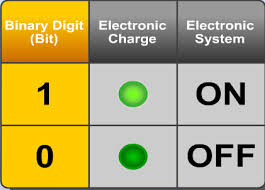

The quantum analogue is the quantum bit or qubit, created using a two-state quantum-mechanical system.  Instead of being either 0 or 1, a qubit can be in a so called superposition (or linear combination) of the two states.

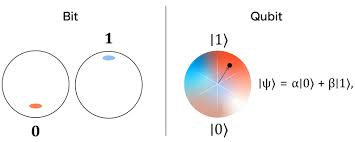

All such possible vectors representing the qubit state lie on the surface of a sphere as shown in the figure above. This sphere is called the Bloch sphere.

When measuring a qubit it is only possible to get one of two possible outcomes, either 0 or 1, as the measurement is a projection of the vector in some (orthogonal) basis.

By measuring the superposition is lost and the state of the qubit is fixed to the state of the measured outcome.

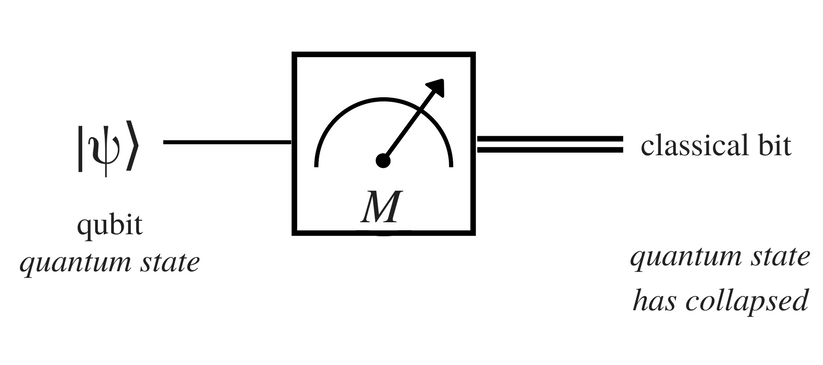

Besides superposition, a qubit has two other quantum mechanical properties which can be used for quantum communication and computation.


*   First, a qubit encodes quantum information that contrary to classical information cannot be copied (no-cloning theorem).
*   Secondly, qubits can be entangled, which means that for a set of entangled qubits the state of each qubit cannot be described independently of the state of the other qubits it is entangled with.



 Any copy machine capable of successfully cloning states |0 and |1 would provide an incorrect result for the superposition state |0+|1. Hence no perfect quantum cloning machine can exist.

  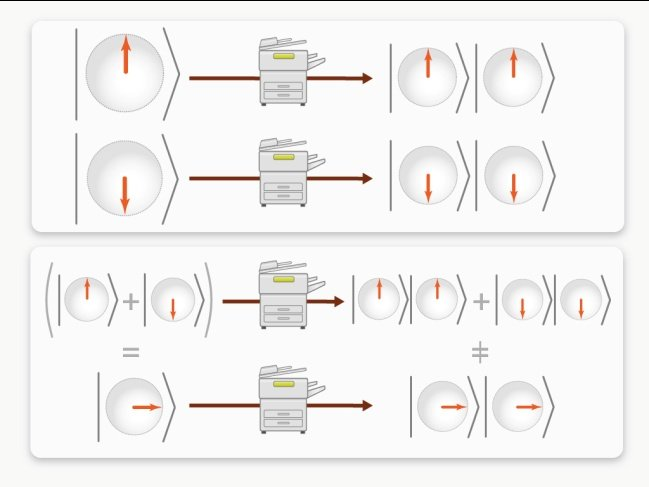

Quantum entanglement is the phenomenon of a group of particles being generated, interacting, or sharing spatial proximity in such a way that the quantum state of each particle of the group cannot be described independently of the state of the others, including when the particles are separated by a large distance.

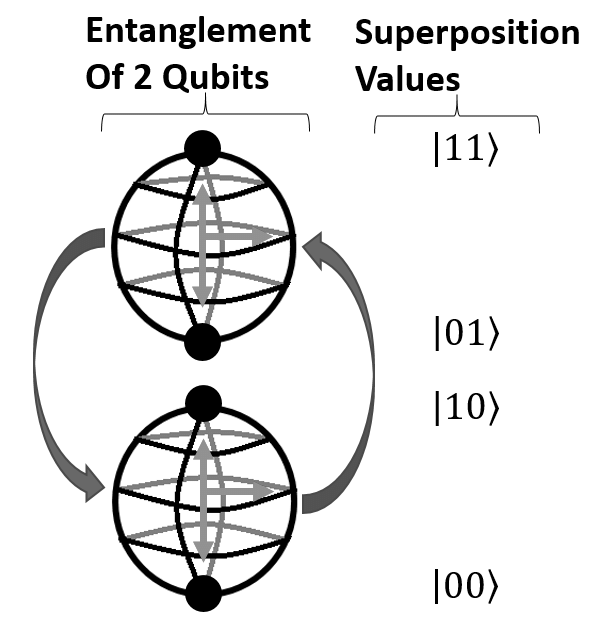

With quantum teleportation a qubit can be moved between different locations without physically transporting the particle (e.g. a photon or electron) representing the qubit.

Teleportation starts with a pair of maximally entangled qubits (an EPR pair) shared between the sender Alice and the receiver Bob. Alice creates a qubit (in state |$\Psi$>) to be teleported and measures it together with her part of the EPR pair in a so called Bell measurement.

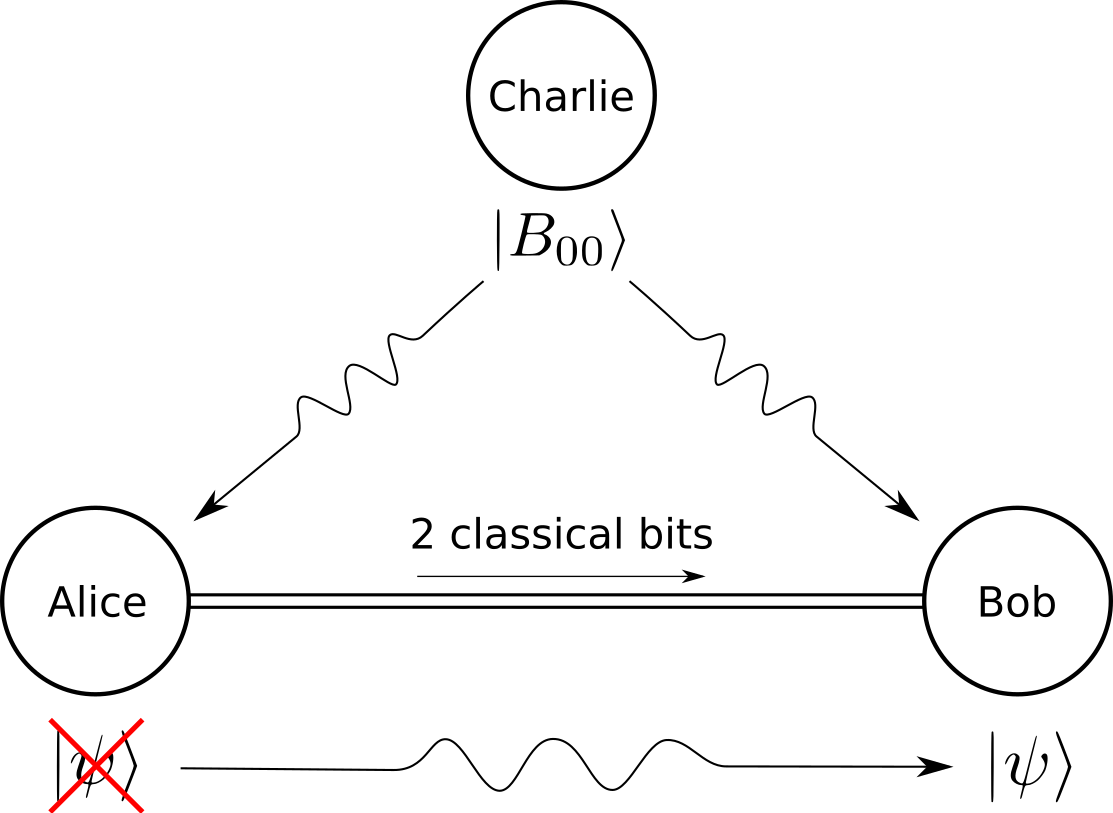

This results in one of four outcomes: 00, 01, 10 or 11. Alice sends the outcome represented by two classical bits over a classical communication channel to Bob. Based on the message received by Bob, he performs one of four single-qubit correction operators on his part of the EPR pair, resulting in his qubit being in the same state as created by Alice.

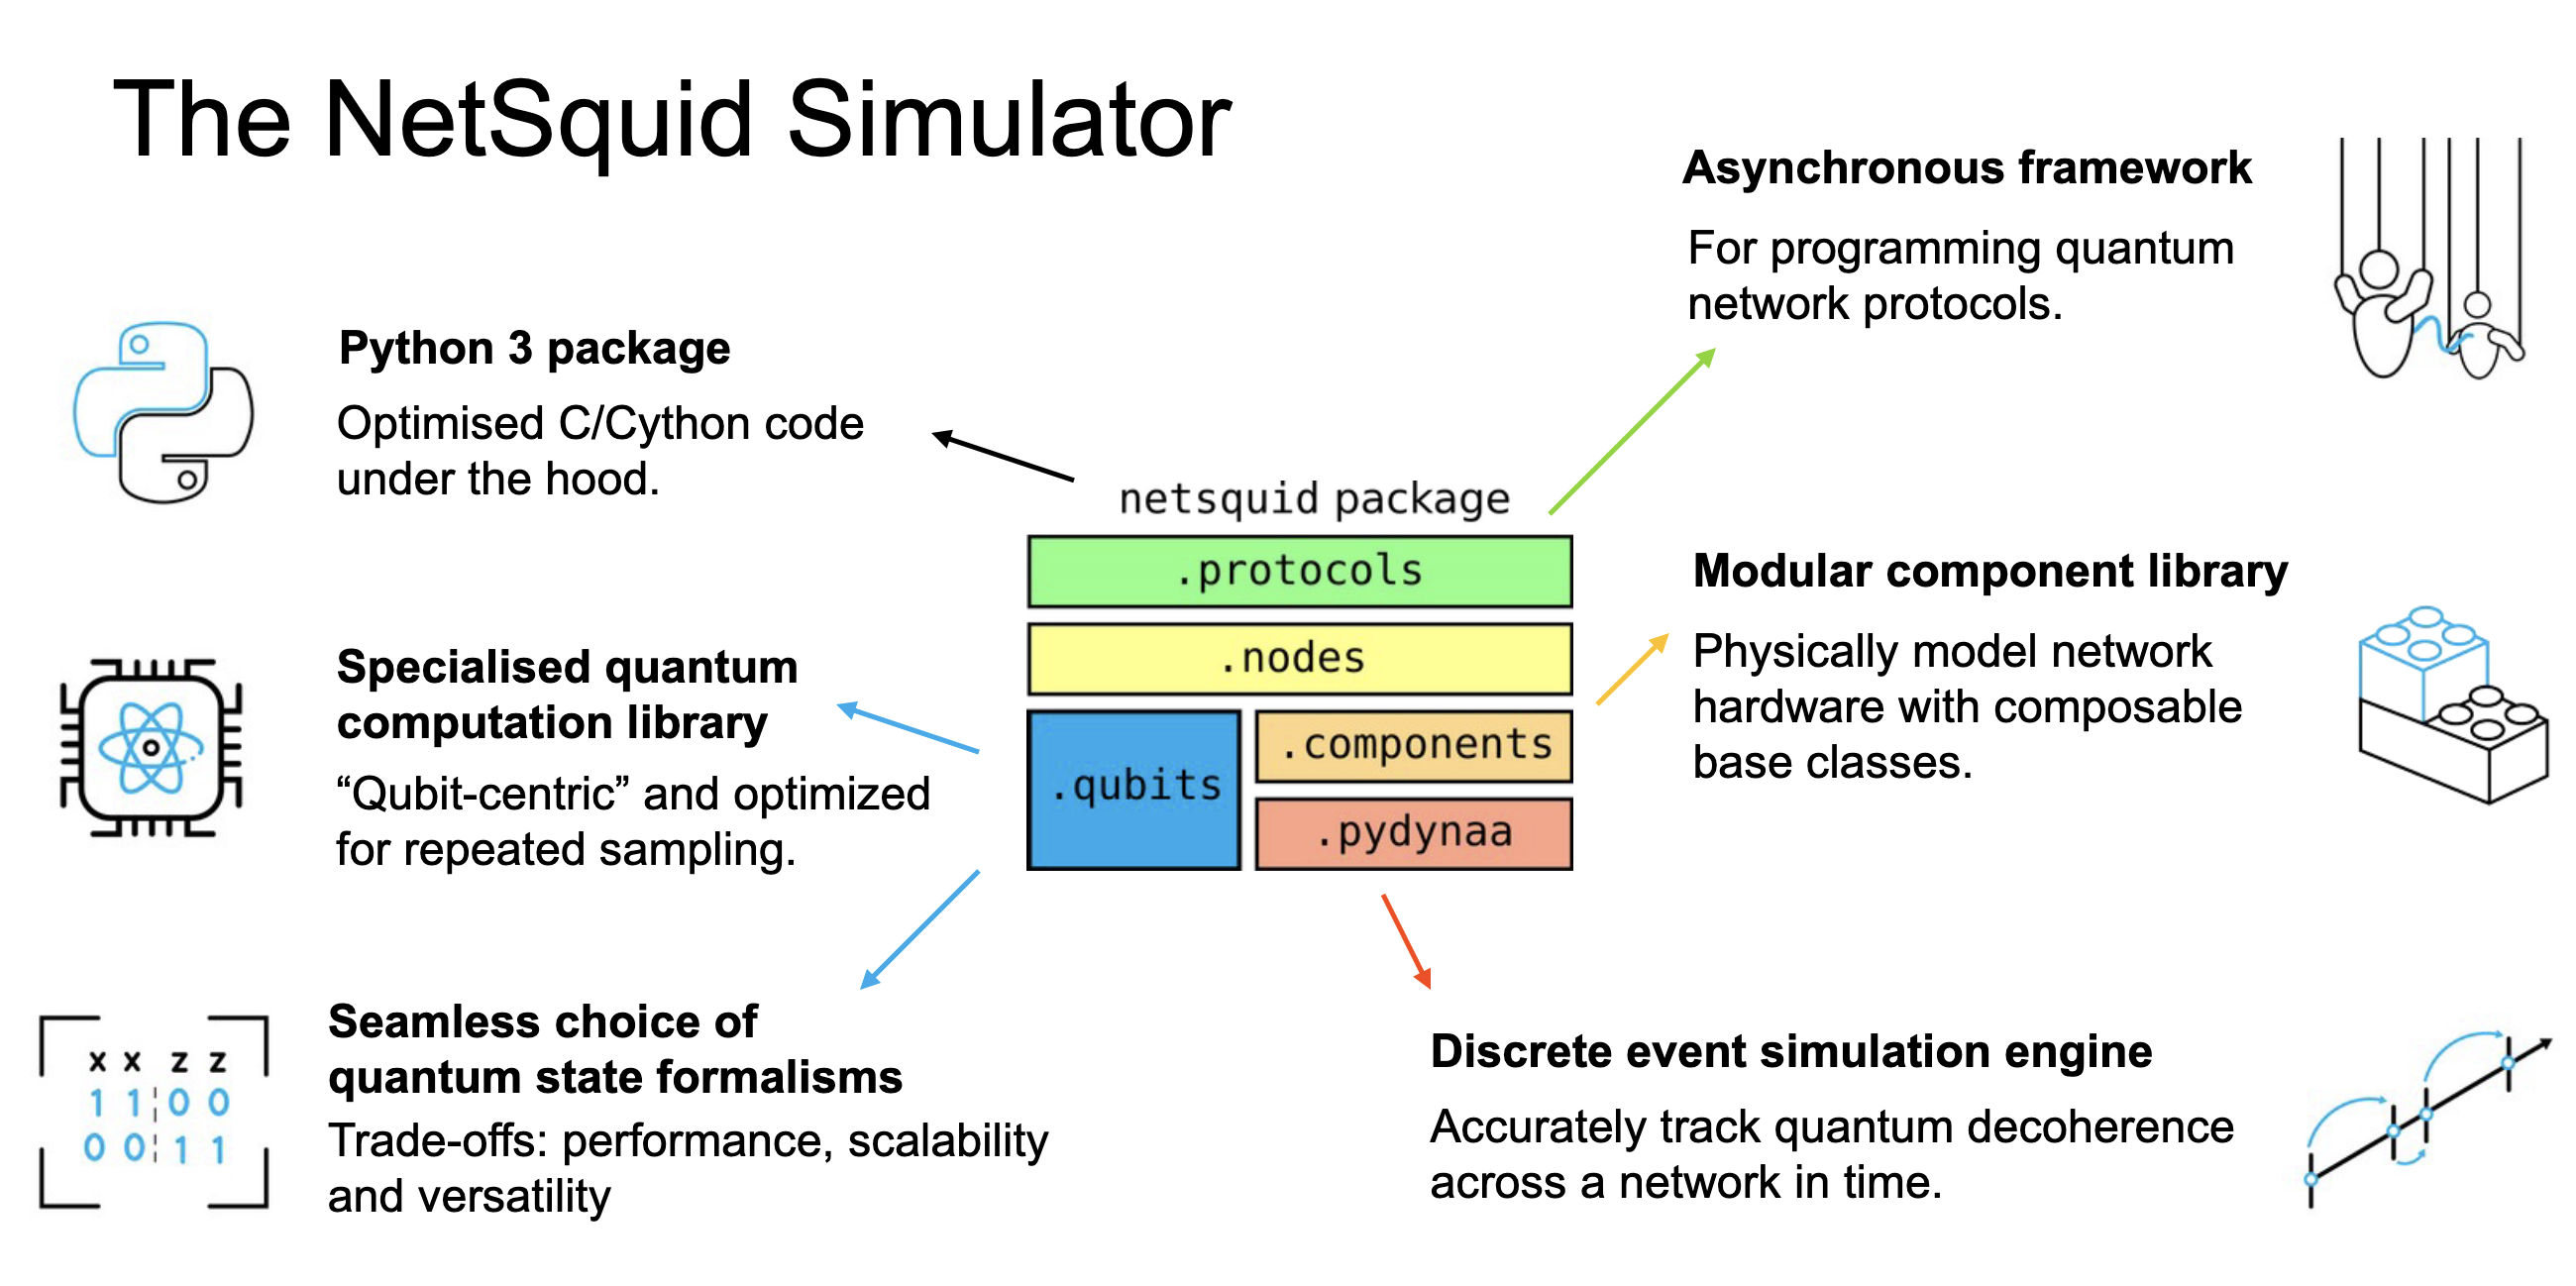

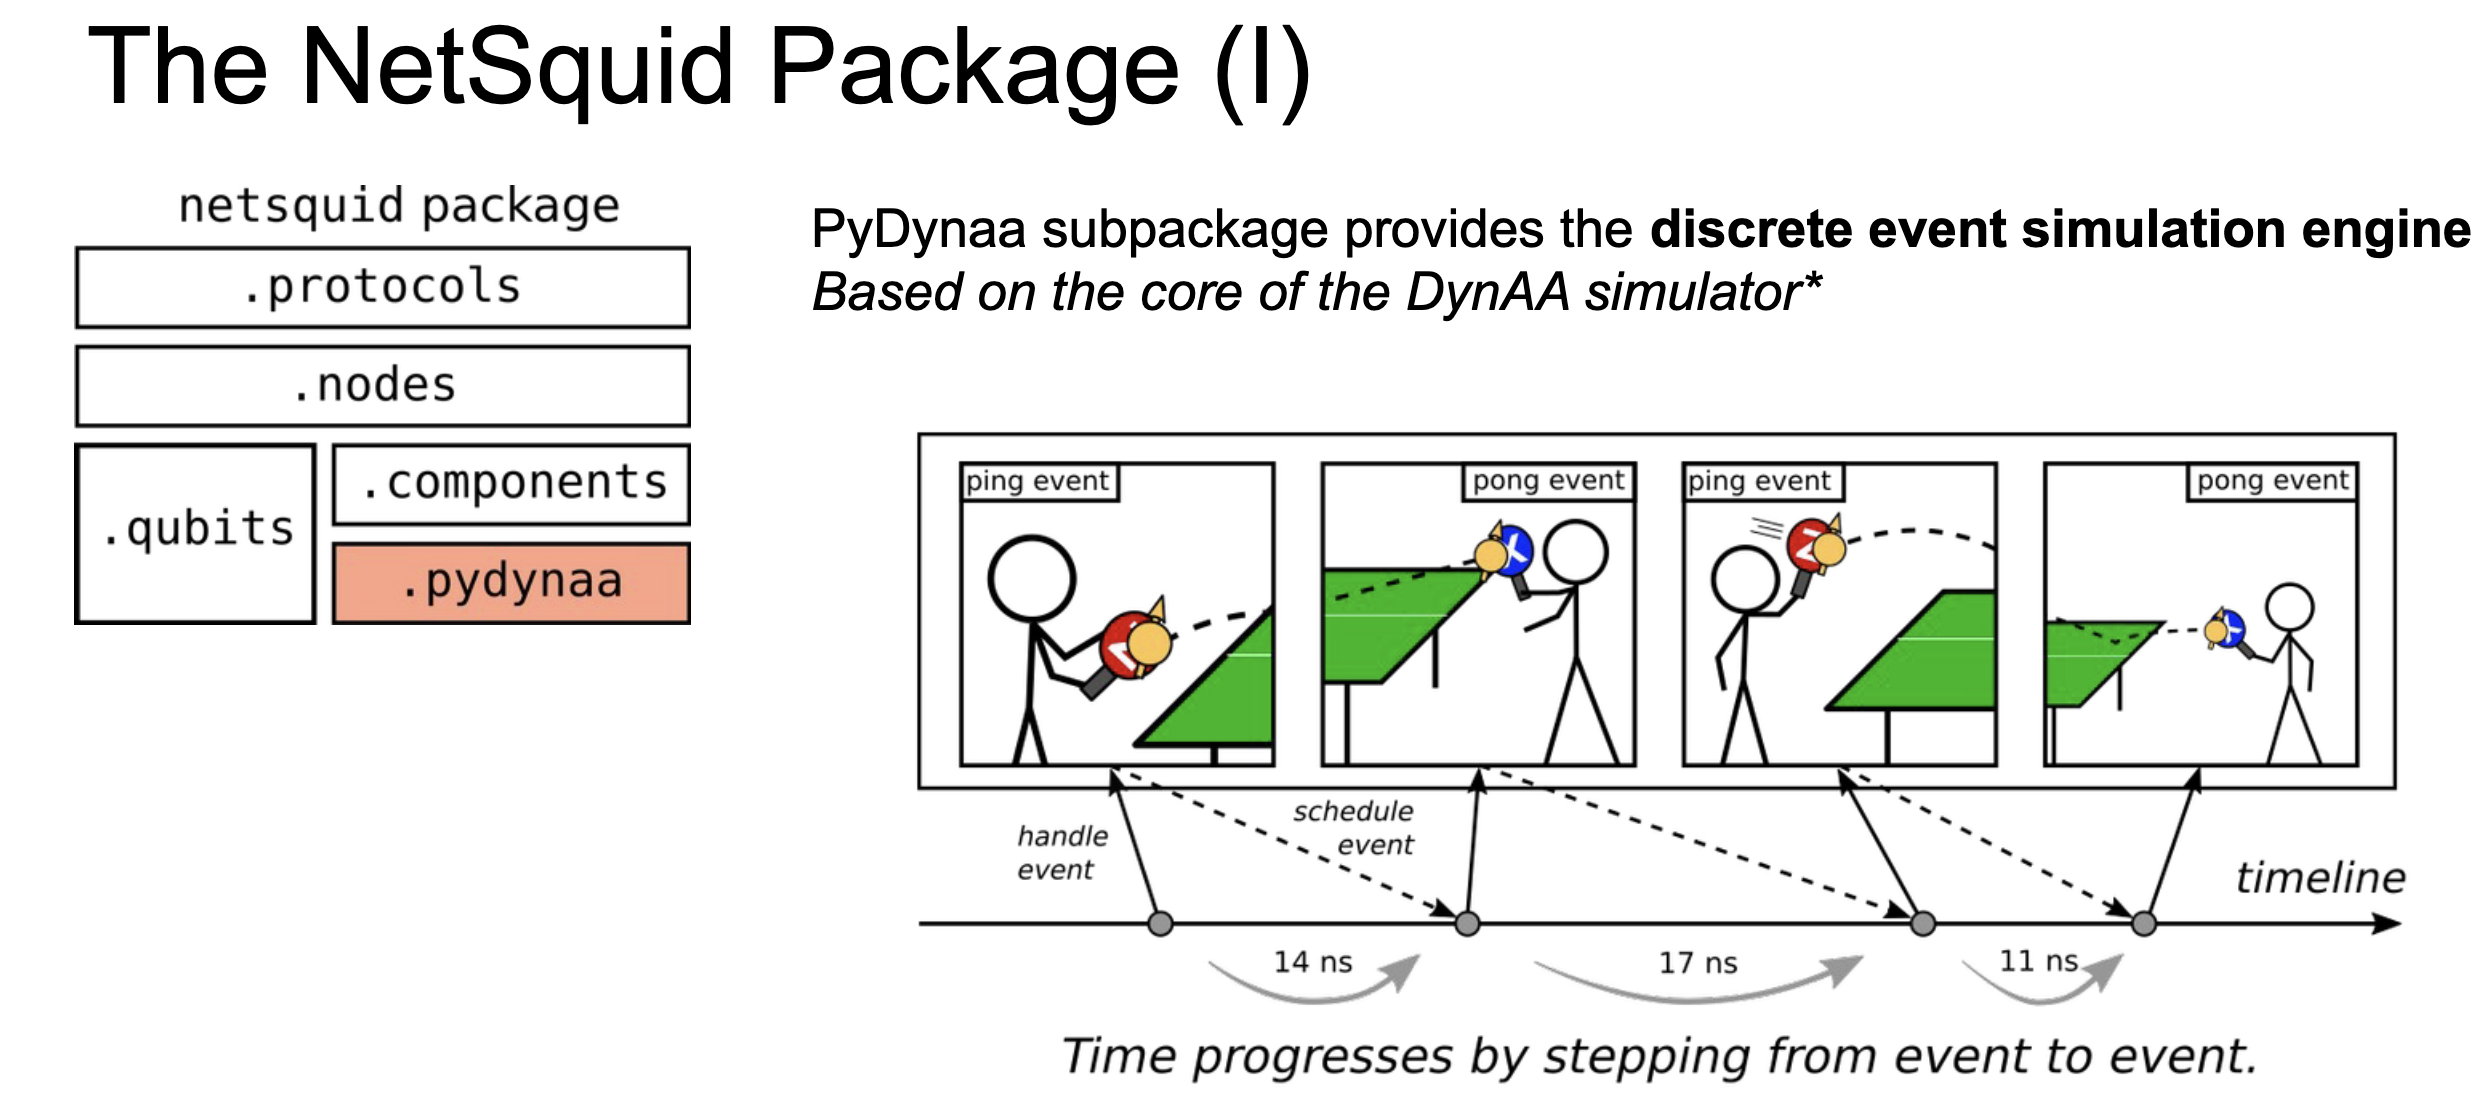

In [ ]:
!pip3 install --extra-index-url https://pypi.netsquid.org netsquid
import netsquid as ns

Looking in indexes: https://pypi.org/simple, https://pypi.netsquid.org


Qubits are represented by Qubit objects. A qubit holds a quantum state (QState), which it may dynamically share with other qubits,

In [ ]:
q1, q2 = ns.qubits.create_qubits(2)

By default each qubit is created in the state |0>. To represent this state, every QState contains a representation (QRepr). The type of representation is determined by the chosen formalism, which is the KET formalism by default.

In [ ]:
q1.qstate.num_qubits

1

In [ ]:
print(q1.qstate.qrepr)

KetRepr(num_qubits=1,
ket=
[[1.+0.j]
 [0.+0.j]])


Measuring a qubit will by default split it from its shared quantum state.

In [ ]:
ns.qubits.measure(q1)

(0, 1.0)

The measure operator returns the measurement result and the probability that it measured that result.

NetSquid offers a formalism agnostic API for manipulating qubits, i.e. the provided functions can be called irrespective of the formalism used for the underlying shared quantum states.

In [ ]:
from netsquid.qubits.qformalism import QFormalism

# Change to density matrix formalism:
ns.set_qstate_formalism(QFormalism.DM)
a1, a2, b1 = ns.qubits.create_qubits(3)

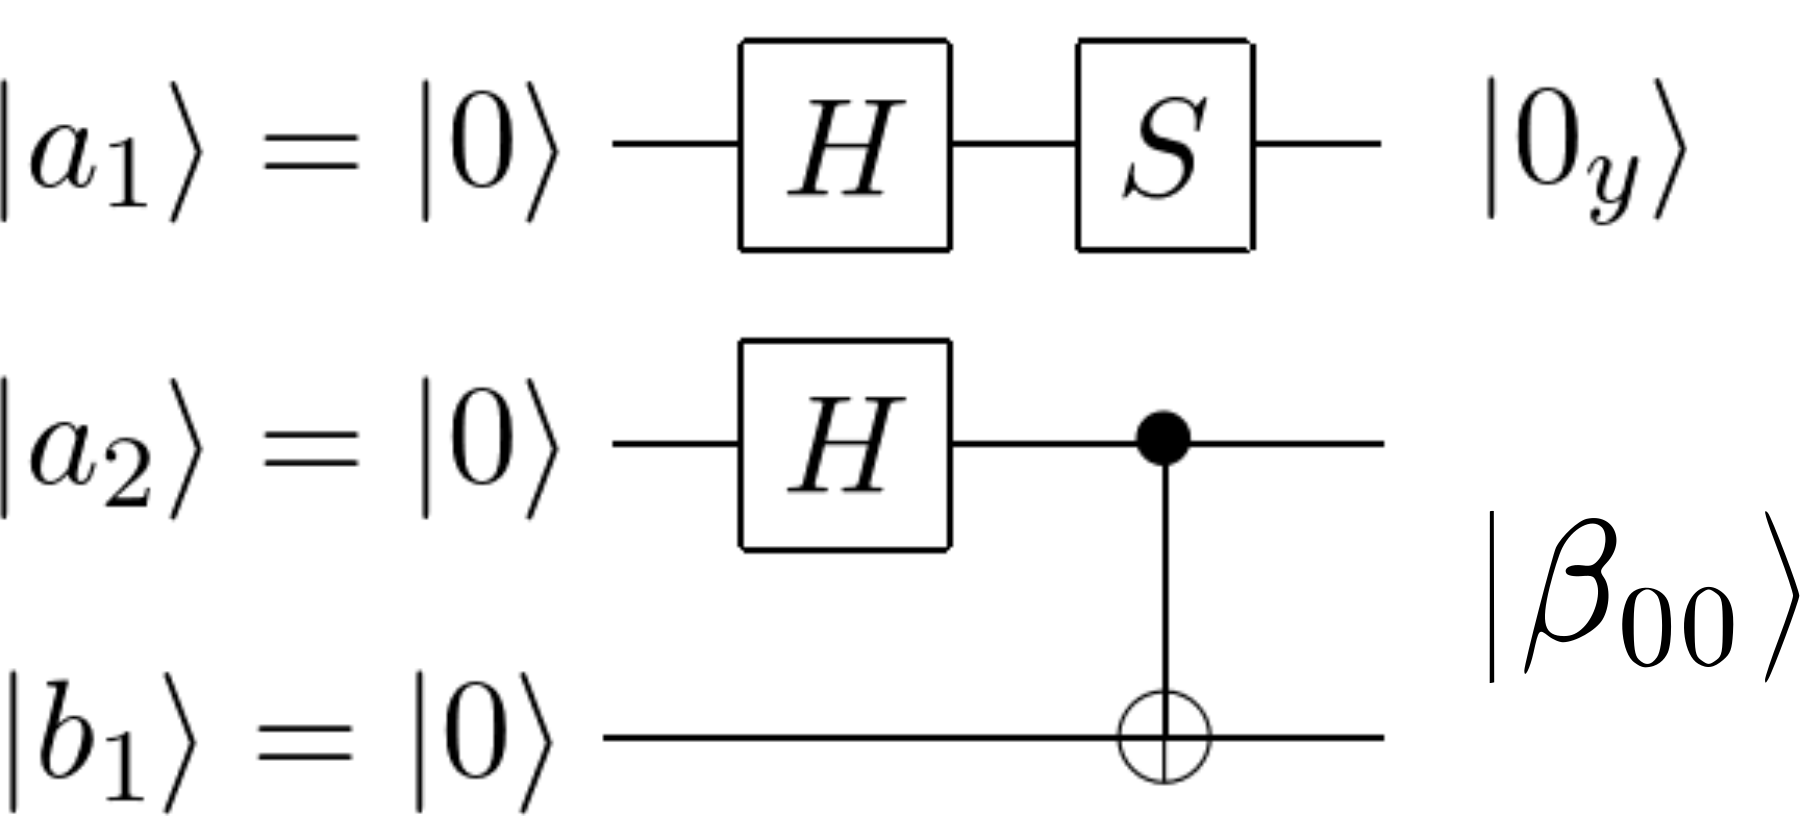

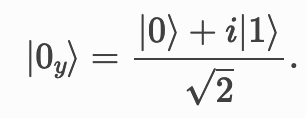

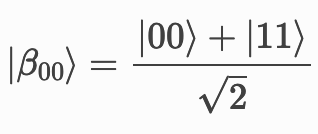

In [ ]:
# put a1 into the chosen target state
ns.qubits.operate(a1, ns.H) # apply Hadamard gate to a1: |0> -> |+>
ns.qubits.operate(a1, ns.S) # apply S gate to a1: |+> -> |0_y>

print(ns.qubits.reduced_dm([a1]))

# transform a2 and b1 to the Bell state |b00> = (|00> + |11>)/sqrt(2)
ns.qubits.operate(a2, ns.H)  # apply Hadamard gate to a2
ns.qubits.operate([a2, b1], ns.CNOT)  # CNOT: a2 = control, b1 = target

print(ns.qubits.reduced_dm([a2, b1]))


[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]


After initialising the qubits, the teleportation protocol proceeds with Alice performing a Bell state measurement on her two qubits. She then sends the two classical bits corresponding to her measurement outcomes to Bob, who performs a possible correction.

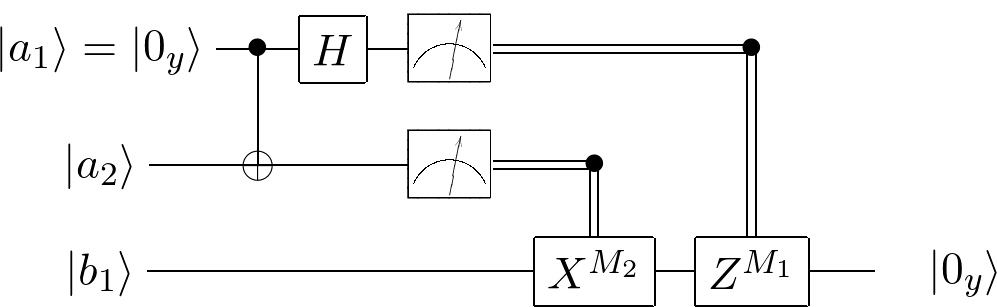

In [ ]:
ns.set_random_state(seed=42)  # (Ensures fixed random outcomes for our doctests)
ns.qubits.operate([a1, a2], ns.CNOT)  # CNOT: a1 = control, a2 = target
ns.qubits.operate(a1, ns.H)

# Measure a1 in the standard basis:
m1, prob = ns.qubits.measure(a1)
labels_z = ("|0>", "|1>")

print(f"Measured {labels_z[m1]} with prob {prob:.2f}")

# Measure a2 in standard basis:
m2, prob = ns.qubits.measure(a2)

print(f"Measured {labels_z[m2]} with prob {prob:.2f}")

Measured |0> with prob 0.50
Measured |1> with prob 0.50


Based on the measurement outcomes of Alice’s Bell state measurement, Bob may need to apply corrections to his qubit to recover the teleported quantum state of Alice.

In [ ]:
if m2 == 1:
    ns.qubits.operate(b1, ns.X)
if m1 == 1:
    ns.qubits.operate(b1, ns.Z)

print(ns.qubits.reduced_dm([b1]))

[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]


We can check how close a qubit is to the desired state by checking the (squared) fidelity of the qubit.

In [ ]:
fidelity = ns.qubits.fidelity(b1, ns.y0, squared=True)

print(f"Fidelity is {fidelity:.3f}")

Fidelity is 1.000


Almost all quantum hardware components are noisy and the quantum state of qubits will decohere with time.

It might be the case that b1 depolarized during the Bell measurement of a1 and a2, which would cause the fidelity of the teleported state to drop:

In [ ]:
ns.qubits.delay_depolarize(b1, depolar_rate=1e7, delay=20)
fidelity = ns.qubits.fidelity([b1], reference_state=ns.y0, squared=True)

print(f"Fidelity is {fidelity:.3f}")

Fidelity is 0.909


Some other functions are available to apply noise or stochastic operations on qubits.

In [ ]:
q1, q2, q3, q4 = ns.qubits.create_qubits(4)

ns.qubits.stochastic_operate(q1, [ns.X, ns.Y, ns.Z], p_weights=(1/2, 1/4, 1/4))
print(ns.qubits.reduced_dm([q1]))

ns.qubits.apply_pauli_noise(q2, p_weights=(1/4, 1/4, 1/4, 1/4))  # (I, X, Y, Z)
print(ns.qubits.reduced_dm([q2]))

ns.qubits.depolarize(q3, prob=0.8)
print(ns.qubits.reduced_dm([q3]))

ns.qubits.operate(q4, ns.X)  # -> |1>
ns.qubits.amplitude_dampen(q4, gamma=0.1, prob=1)

print(ns.qubits.reduced_dm([q4]))

[[0.25+0.j 0.  +0.j]
 [0.  +0.j 0.75+0.j]]
[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
[[0.6+0.j 0. +0.j]
 [0. +0.j 0.4+0.j]]
[[0.1+0.j 0. +0.j]
 [0. +0.j 0.9+0.j]]


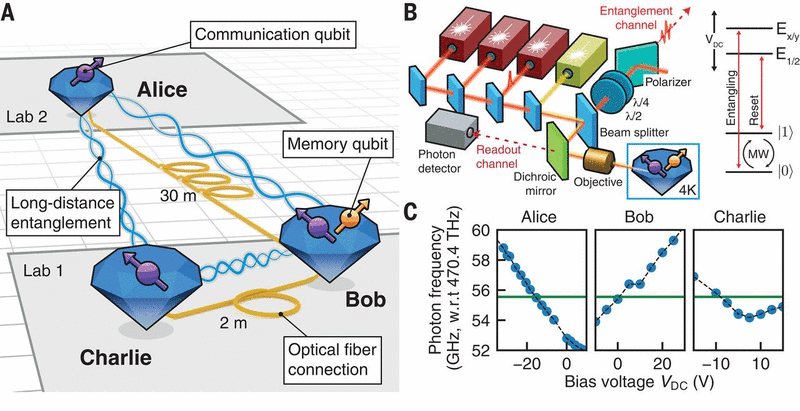

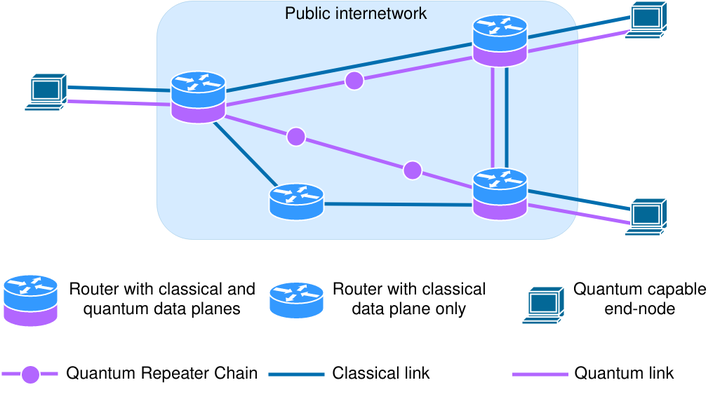

NetSquid encompasses various kind fo components to make a quantum network:quantum and classical channels, quantum memories, quantum sources, and quantum processors.

Components are composed of four types of attributes: properties that define their physical characteristics, models that describe functional behaviour, ports for input and output communication, and possible subcomponents that they are built out of.

To send a message from Alice to Bob, we need a component implementing this functionality of sending a message with a delay, which is a channel.

In [ ]:
from netsquid.components import Channel, QuantumChannel

channel = Channel(name="MyChannel")

A channel is capable of sending a message in one direction i.e. from its input port at one end to its output port at the other end.

In [ ]:
channel.send("hello world!")

ns.sim_run()

SimStats()

In [ ]:
items, delay = channel.receive()

items

['hello world!']

In [ ]:
delay

0.0

There are multiple ways to add a delay to the channel.

In [ ]:
Channel(name="DelayChannel", delay=10)

Channel(name='DelayChannel')

Another approach is to specify a delay model (DelayModel), a specific subclass of the Model base class used to generate delays. In general models are used by components to modify their behaviour.

Several delay models have been predefined for convenience.

In [ ]:
from netsquid.components.models.delaymodels import FixedDelayModel

fixed_delaymodel = FixedDelayModel(delay=10)

channel.models['delay_model'] = fixed_delaymodel
channel.send("hello world!")
ns.sim_run()

channel.receive()

(['hello world!'], 10.0)

In [ ]:
from netsquid.components.models.delaymodels import GaussianDelayModel

gaussian_delaymodel = GaussianDelayModel(delay_mean=5, delay_std=0.1)

In [ ]:
Channel("TutorialChannel", length=10)
channel.properties['length'] = 10

from netsquid.components.models.delaymodels import FibreDelayModel

delay_model = FibreDelayModel()

print(f"Speed of light in fibre: {delay_model.properties['c']:.1f} [km/s]")

delay_model.required_properties

Speed of light in fibre: 200000.0 [km/s]


['length']

Aside from using channels to send classical messages as we have been doing so far, we will naturally also want to transmit qubits (Qubit). To do so we will need our channel to model not only the transmission delay but also to account for any possible quantum noise or loss (attenuation) the qubits experience due to that delay and the channel’s physical characteristics. For that purpose there is the quantum channel (QuantumChannel), which is intended for the transmission of qubits (and only qubits). Besides modeling the transmission delay using a delay model, it also specifies two new model types:


*   a quantum_noise_model that models noise experienced by qubits during their transmission,
*   a quantum_loss_model that determines whether the transmitted qubits are lost.




In [ ]:
from netsquid.components.models.qerrormodels import FibreLossModel
from netsquid.components.qchannel import QuantumChannel

loss_model = FibreLossModel(p_loss_init=0.83, p_loss_length=0.2)
qchannel = QuantumChannel("MyQChannel", length=20, models={'quantum_loss_model': loss_model})

Analogous to the quantum channel for qubits, there also exists the classical channel base class (ClassicalChannel) for transmitting classical information. It also allows specifying noise and loss models.

While quantum channels are used to transmit qubits, we also need a place to store qubits and to account for any decoherence they experience while they wait. The component that is designed to handle qubit storage is the quantum memory.

A quantum memory contains slots for storing qubits called memory positions. We can add error models to the memory positions that will apply noise to qubits, which is (optionally) proportional to the time they have been idly waiting.

In [ ]:
from netsquid.components.models.qerrormodels import DepolarNoiseModel

depolar_noise = DepolarNoiseModel(depolar_rate=1e6)  # the depolar_rate is in Hz

A quantum memory can have multiple memory positions that can each be assigned its own error model.

In [ ]:
from netsquid.components.qmemory import QuantumMemory

qmem = QuantumMemory("DepolarMemory", num_positions=2, memory_noise_models=[depolar_noise, depolar_noise])

To insert a qubit into a quantum memory, it can be put() into the memory. To get it back out again, we can pop() it from the memory. If we only want to verify it is in the memory, we can peek() at it.

In [ ]:
from netsquid.qubits.qubitapi import create_qubits

qubits = create_qubits(1)
qmem.put(qubits)
qmem.peek(0)

[Qubit('QS#3-0')]

In [ ]:
qmem.pop(positions=0)

[Qubit('QS#3-0')]

In [ ]:
qmem.peek(0)

[None]

Finally a quantum memory can also measure the qubits.

In [ ]:
import netsquid.qubits.operators as ops

qubits = create_qubits(1)
qmem.put(qubits)

qmem.measure(positions=[0], observable=ops.X)

([1], [0.4999999999999998])

We want the qubit to be physically transported between the two players using channels, and to automatically transfer the qubit from the channel to the quantum memory when it arrives. Both the channel and quantum memory are components, and all components share the same interface for communication, namely ports (Port). Ports allow for modularity.

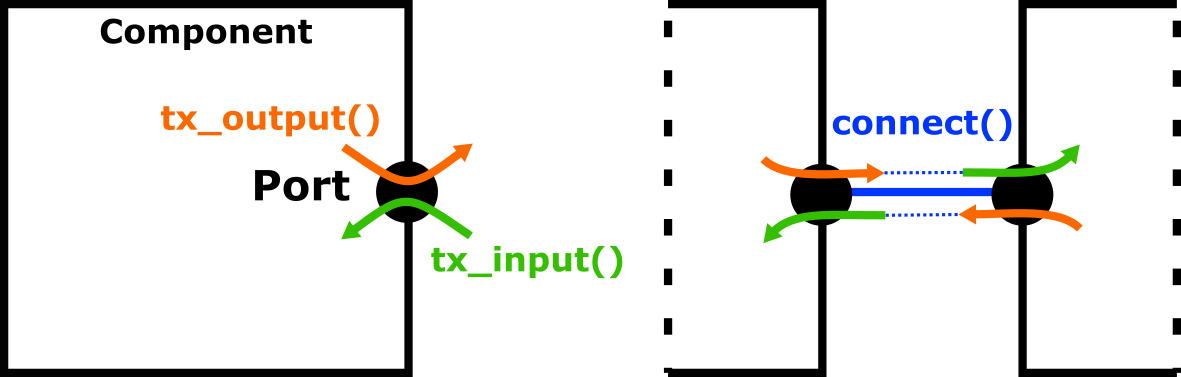

Previously we used the methods send() and receive() of the Channel class. These are actually convenience methods that make use of the send and recv ports on a channel, respectively.

In [ ]:
channel = Channel("TutorialChannel", delay=3)
channel.ports['send'].tx_input("hello")
ns.sim_run()
channel.ports['recv'].rx_output()

Message(items=['hello'], header=None, ch_delta_time=3.0)

Ports expect to transmit (TX) and receive (RX) message objects.

Two ports can be connected using the connect() method, which will directly pass transmitted output from one port to the received input of the other, and vice versa.

We want to send the qubit via the channel and store it in the quantum memory on the receiving side. As shown earlier, a quantum memory can use put() to store a qubit. An alternative to put is to send a message containing a list of qubits to the qin port of the quantum memory, or a message with a single qubit to a specific qinX port, where X is the index of a specific memory position. When we connect this port to the receive port of the channel, the arrived qubit will be automatically stored.

In [ ]:
channel.ports['recv'].connect(qmem.ports['qin0'])

With the ports connected we can send our qubit via the channel and have it automatically passed onto the quantum memory on the other side:

In [ ]:
qubit, = create_qubits(1)
print(qubit)


channel.send(qubit)
ns.sim_run()

qmem.peek(0)

Qubit('QS#5-0')


[Qubit('QS#5-0')]

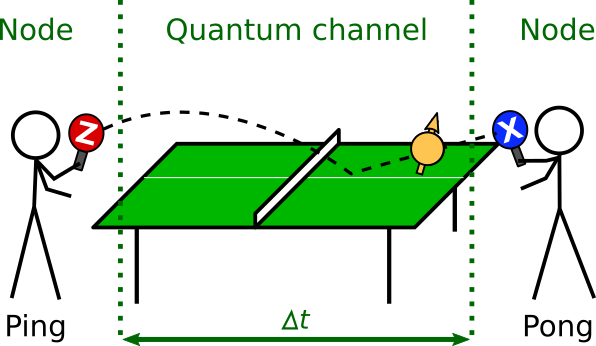

In [ ]:
!pip3 install --extra-index-url https://pypi.netsquid.org  pydynaa

Looking in indexes: https://pypi.org/simple, https://pypi.netsquid.org


In [ ]:
import pydynaa
from netsquid.components.component import Port

class PingEntity(pydynaa.Entity):
    length = 2e-3  # channel length [km]

    def __init__(self):
        # Create a memory and a quantum channel:
        self.qmemory = QuantumMemory("PingMemory", num_positions=1)
        self.qchannel = QuantumChannel("PingChannel", length=self.length,
                                       models={"delay_model": FibreDelayModel()})

        # link output from qmemory (pop) to input of ping channel:
        self.qmemory.ports["qout"].connect(self.qchannel.ports["send"])

        # Setup callback function to handle input on quantum memory port "qin0":
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin0"], event_type=Port.evtype_input)
        self.qmemory.ports["qin0"].notify_all_input = True

    def start(self, qubit):
        # Start the game by having ping player send the first qubit (ping)
        self.qchannel.send(qubit)

    def wait_for_pong(self, other_entity):
        # Setup this entity to pass incoming qubits to its quantum memory
        self.qmemory.ports["qin0"].connect(other_entity.qchannel.ports["recv"])

    def _handle_input_qubit(self, event):
        # Callback function called by the pong handler when pong event is triggered
        [m], [prob] = self.qmemory.measure(positions=[0], observable=ns.Z)
        labels_z = ("|0>", "|1>")
        print(f"{ns.sim_time():.1f}: Pong event! PingEntity measured "
              f"{labels_z[m]} with probability {prob:.2f}")
        self.qmemory.pop(positions=[0])

class PongEntity(pydynaa.Entity):
    length = 2e-3  # channel length [km]

    def __init__(self):
        # Create a memory and a quantum channel:
        self.qmemory = QuantumMemory("PongMemory", num_positions=1)
        self.qchannel = QuantumChannel("PingChannel", length=self.length,
                                       models={"delay_model": FibreDelayModel()})

        # link output from qmemory (pop) to input of ping channel:
        self.qmemory.ports["qout"].connect(self.qchannel.ports["send"])

        # Setup callback function to handle input on quantum memory:
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin0"], event_type=Port.evtype_input)
        self.qmemory.ports["qin0"].notify_all_input = True

    def wait_for_ping(self, other_entity):
        # Setup this entity to pass incoming qubits to its quantum memory
        self.qmemory.ports["qin0"].connect(other_entity.qchannel.ports["recv"])

    def _handle_input_qubit(self, event):
        # Callback function called by the pong handler when pong event is triggered
        [m], [prob] = self.qmemory.measure(positions=[0], observable=ns.X)
        labels_x = ("|+>", "|->")
        print(f"{ns.sim_time():.1f}: Ping event! PongEntity measured "
              f"{labels_x[m]} with probability {prob:.2f}")
        self.qmemory.pop(positions=[0])

In [ ]:
ns.sim_reset()
ping = PingEntity()
pong = PongEntity()
ping.wait_for_pong(pong)
pong.wait_for_ping(ping)

# Create a qubit and instruct the ping entity to start
qubit, = ns.qubits.create_qubits(1)
ping.start(qubit)

In [ ]:
ns.set_random_state(seed=42)
stats = ns.sim_run(91)

10.0: Ping event! PongEntity measured |+> with probability 0.50
20.0: Pong event! PingEntity measured |1> with probability 0.50
30.0: Ping event! PongEntity measured |-> with probability 0.50
40.0: Pong event! PingEntity measured |1> with probability 0.50
50.0: Ping event! PongEntity measured |+> with probability 0.50
60.0: Pong event! PingEntity measured |0> with probability 0.50
70.0: Ping event! PongEntity measured |+> with probability 0.50
80.0: Pong event! PingEntity measured |1> with probability 0.50
90.0: Ping event! PongEntity measured |-> with probability 0.50


In [ ]:
print(stats)


Simulation summary

Elapsed wallclock time: 0:00:00.011643
Elapsed simulation time: 9.10e+01 [ns]
Triggered events: 27
Handled callbacks: 18
Total quantum operations: 9
Frequent quantum operations: MEASURE = 9
Max qstate size: 1 qubits
Mean qstate size: 1.00 qubits



In [ ]:
ns.sim_reset()

Let's extend this example with components and again switch to the density matrix formalism to demonstrate the effects on noise on the final fidelity without the need of sampling.

In [ ]:
class Alice(pydynaa.Entity):

    def __init__(self, teleport_state, cchannel_send_port):
        self.teleport_state = teleport_state
        self.cchannel_send_port = cchannel_send_port
        self.qmemory = QuantumMemory("AliceMemory", num_positions=2)
        self._wait(pydynaa.EventHandler(self._handle_input_qubit),
                   entity=self.qmemory.ports["qin1"], event_type=Port.evtype_input)
        self.qmemory.ports["qin1"].notify_all_input = True

    def _handle_input_qubit(self, event):
        # Callback function that does teleportation and
        # schedules a corrections ready event
        q0, = ns.qubits.create_qubits(1, no_state=True)
        ns.qubits.assign_qstate([q0], self.teleport_state)
        self.qmemory.put([q0], positions=[0])
        self.qmemory.operate(ns.CNOT, positions=[0, 1])
        self.qmemory.operate(ns.H, positions=[0])

        m0, m1 = self.qmemory.measure(positions=[0, 1], observable=ns.Z,
                                      discard=True)[0]

        self.cchannel_send_port.tx_input([m0, m1])
        print(f"{ns.sim_time():.1f}: Alice received entangled qubit, "
              f"measured qubits & sending corrections")

class Bob(pydynaa.Entity):

    depolar_rate = 1e7  # depolarization rate of waiting qubits [Hz]

    def __init__(self, cchannel_recv_port):
        noise_model = DepolarNoiseModel(depolar_rate=self.depolar_rate)
        self.qmemory = QuantumMemory("BobMemory", num_positions=1,
                                     memory_noise_models=[noise_model])
        cchannel_recv_port.bind_output_handler(self._handle_corrections)

    def _handle_corrections(self, message):
        # Callback function that handles messages from both Alice and Charlie
        m0, m1 = message.items

        if m1:
            self.qmemory.operate(ns.X, positions=[0])
        if m0:
            self.qmemory.operate(ns.Z, positions=[0])
        qubit = self.qmemory.pop(positions=[0])

        fidelity = ns.qubits.fidelity(qubit, ns.y0, squared=True)
        print(f"{ns.sim_time():.1f}: Bob received entangled qubit and corrections!"
              f" Fidelity = {fidelity:.3f}")

We see that Alice will wait for a qubit to arrive on her memory from Charlie, perform the Bell measurement as before, then send the classical corrections via the port she holds to Bob. For Bob we have this time assumed  that the corrections from Alice will arrive after his qubit from Charlie, which means we can avoid using event expressions as before.

Regarding Charlie, rather than again defining a simulation entity class, we will instead automate his entanglement generation completely using components. A new component we need to replace Charlie is the quantum source (QSource), which we will connect to Alice and Bob via quantum channels.


In [ ]:
from netsquid.qubits.state_sampler import StateSampler
import netsquid.qubits.ketstates as ks

state_sampler = StateSampler([ks.b00], [1.0])

Because we want to send the two generated qubits in different directions, one for Alice and one for Bob, we will specify two output ports to the quantum source constructor with the default names qout0 and qout1.

In [ ]:
from netsquid.components.qsource import QSource, SourceStatus

charlie_source = QSource("Charlie", state_sampler, frequency=50, num_ports=2,
                         timing_model=FixedDelayModel(delay=50),
                         status=SourceStatus.INTERNAL)

To setup the network to generate entanglement for Alice and Bob, we connect the output ports of the quantum source to two one-way quantum channels, which we in turn connect to the inputs on the quantum memories of Alice and Bob:

In [ ]:
def setup_network(alice, bob, qsource, length=4e-3):
    qchannel_c2a = QuantumChannel("Charlie->Alice", length=length / 2,
                                  models={"delay_model": FibreDelayModel()})

    qchannel_c2b = QuantumChannel("Charlie->Bob", length=length / 2,
                                  models={"delay_model": FibreDelayModel()})

    qsource.ports['qout0'].connect(qchannel_c2a.ports['send'])
    qsource.ports['qout1'].connect(qchannel_c2b.ports['send'])
    alice.qmemory.ports['qin1'].connect(qchannel_c2a.ports['recv'])
    bob.qmemory.ports['qin0'].connect(qchannel_c2b.ports['recv'])

We can now create the Alice and Bob entities together with a classical channel between them, and call the network setup:

In [ ]:
from netsquid.components import ClassicalChannel

cchannel = ClassicalChannel("CChannel", length=4e-3,
                            models={"delay_model": FibreDelayModel()})
alice = Alice(teleport_state=ns.y0, cchannel_send_port=cchannel.ports["send"])
bob = Bob(cchannel_recv_port=cchannel.ports["recv"])
setup_network(alice, bob, charlie_source)

In [ ]:
stats = ns.sim_run(end_time=100)

10.0: Alice received entangled qubit, measured qubits & sending corrections
30.0: Bob received entangled qubit and corrections! Fidelity = 0.909
60.0: Alice received entangled qubit, measured qubits & sending corrections
80.0: Bob received entangled qubit and corrections! Fidelity = 0.909


In [ ]:
print(stats)


Simulation summary

Elapsed wallclock time: 0:00:00.010147
Elapsed simulation time: 1.00e+02 [ns]
Triggered events: 20
Handled callbacks: 12
Total quantum operations: 17
Frequent quantum operations: MEASURE = 4; X = 3; Z = 2; Y = 2; I = 2, ...
Max qstate size: 3 qubits
Mean qstate size: 1.82 qubits



The quantum noise has now been handled automatically by the quantum memories.

In [ ]:
ns.sim_reset()

Let's organise things further by composing these components together into nodes and connections, two examples of composite components.

Nodes represent the location entities of a quantum network, where all operations are local, and are examples of a composite component that holds and manages sub-components via its subcomponents attribute.

Up to this point in the tutorial Alice and Bob have been generic simulation entities (Entity).

In [ ]:
from netsquid.nodes import Node

alice = Node("Alice")

In [ ]:
from netsquid.components import QuantumMemory

qmemory = QuantumMemory("AliceMemory", num_positions=2)
alice.add_subcomponent(qmemory, name="memory1")
alice.subcomponents["memory1"]

QuantumMemory(name='AliceMemory')

Nodes, like any component, can have ports. Because it is not possible to connect ports between components with different supercomponents (parents), a node’s ports serve as the external interface for all their sub-components. This helps to enforce locality, which we will see again when we discuss protocols. A node’s sub-component can communicate via a node’s ports via forwarding i.e. it can forward it’s output or receive forwarded input.

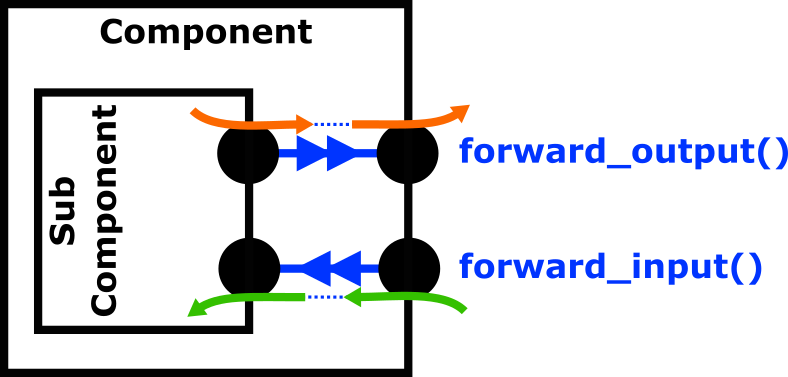

In [ ]:
alice.add_ports(['qin_charlie'])
alice.ports['qin_charlie'].forward_input(alice.qmemory.ports['qin'])


Any messages that are transmitted as input to Alice’s qin_charlie port will be directly forwarded as input to her memory’s qin port.

By using port forwarding the node becomes the only exposed interface. The recommended practice is to connect remote nodes using connection components

aafig-bbbbe9a4fb51544b610842f726b1e55b00d50691.svg

In [ ]:
from netsquid.nodes.connections import Connection
from netsquid.components import ClassicalChannel
from netsquid.components.models import FibreDelayModel

class ClassicalConnection(Connection):

    def __init__(self, length):
        super().__init__(name="ClassicalConnection")
        self.add_subcomponent(ClassicalChannel("Channel_A2B", length=length,
            models={"delay_model": FibreDelayModel()}))
        self.ports['A'].forward_input(
            self.subcomponents["Channel_A2B"].ports['send'])
        self.subcomponents["Channel_A2B"].ports['recv'].forward_output(
            self.ports['B'])

Alternativelly

In [ ]:
cconnection = Connection("ClassicalConnection")
cchannel = ClassicalChannel("Channel_A2B")
cconnection.add_subcomponent(cchannel,
                             forward_input=[("A", "send")],
                             forward_output=[("B", "recv")])

A more interesting connection can be constructed to encompass the whole entanglement generation machinery of Charlie.

aafig-bb64252ef6c7bb51ecbbacba9707d1288ceb73aa.svg

In [ ]:
from netsquid.components.qchannel import QuantumChannel
from netsquid.qubits import StateSampler
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.models import FixedDelayModel, DepolarNoiseModel
import netsquid.qubits.ketstates as ks

class EntanglingConnection(Connection):

    def __init__(self, length, source_frequency):
        super().__init__(name="EntanglingConnection")
        timing_model = FixedDelayModel(delay=(1e9 / source_frequency))
        qsource = QSource("qsource", StateSampler([ks.b00], [1.0]), num_ports=2,
                          timing_model=timing_model,
                          status=SourceStatus.INTERNAL)
        self.add_subcomponent(qsource)
        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})

        # Add channels and forward quantum channel output to external port output:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])

        # Connect qsource output to quantum channel input:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"])
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])

The internal clock in the quantum source will automatically trigger this connection to generate entangled qubits and send them as output to its remote ports A and B via quantum channels.

In [ ]:
def example_network_setup(node_distance=4e-3, depolar_rate=1e7):
    # Setup nodes Alice and Bob with quantum memories:
    noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)
    alice = Node(
        "Alice", port_names=['qin_charlie', 'cout_bob'],
        qmemory=QuantumMemory("AliceMemory", num_positions=2,
                              memory_noise_models=[noise_model] * 2))

    alice.ports['qin_charlie'].forward_input(alice.qmemory.ports['qin1'])
    bob = Node(
        "Bob", port_names=['qin_charlie', 'cin_alice'],
        qmemory=QuantumMemory("BobMemory", num_positions=1,
                              memory_noise_models=[noise_model]))

    bob.ports['qin_charlie'].forward_input(bob.qmemory.ports['qin0'])

    # Setup classical connection between nodes:
    c_conn = ClassicalConnection(length=node_distance)
    alice.ports['cout_bob'].connect(c_conn.ports['A'])
    bob.ports['cin_alice'].connect(c_conn.ports['B'])

    # Setup entangling connection between nodes:
    q_conn = EntanglingConnection(length=node_distance, source_frequency=2e7)
    alice.ports['qin_charlie'].connect(q_conn.ports['A'])
    bob.ports['qin_charlie'].connect(q_conn.ports['B'])

    return alice, bob, q_conn, c_conn

We can test part of our network by checking that after one cycle the entangled qubits have arrived on both quantum memories:

In [ ]:
ns.set_qstate_formalism(ns.QFormalism.DM)
alice, bob, *_ = example_network_setup()
stats = ns.sim_run(15)
qA, = alice.qmemory.peek(positions=[1])
qB, = bob.qmemory.peek(positions=[0])

qA, qB

(Qubit('qsource-#1-0'), Qubit('qsource-#1-1'))

In [ ]:
fidelity = ns.qubits.fidelity([qA, qB], ns.b00)
print(f"Entangled fidelity (after 5 ns wait) = {fidelity:.3f}")

Entangled fidelity (after 5 ns wait) = 0.964


In [ ]:
ns.sim_reset()

In contrast to components, which represent physical entities in a simulation (the hardware), protocols are virtual simulation entities that steer component behaviour (the software). For example, a protocol may instruct a quantum processor to measure one of its qubits upon receiving a classical message on one of its node’s ports. Let's see how to use protocols to teleport a qubit from Alice to Bob.

The main protocol methods are:


*   start() - starts the protocol and generally resets any state variables.

*   stop() - stops the protocol but should not modify any state variables.

*   reset() - stops and then restarts the protocol.

*   run() - Here the flow of the protocol can be defined.



In [ ]:
from netsquid.protocols import Protocol

class WaitProtocol(Protocol):

    def run(self):
        print(f"Starting protocol at {ns.sim_time()}")
        yield self.await_timer(100)
        print(f"Ending protocol at {ns.sim_time()}")

ns.sim_reset()
protocol = WaitProtocol()
protocol.start()

stats = ns.sim_run()

Starting protocol at 0.0
Ending protocol at 100.0


When a protocol has finished it sends a FINISHED signal to inform any listening entities. Signals are events of a specific type and with an optional result. There are several other predefined signal types, notably SUCCESS and FAIL. A protocol can send signals using the send_signal() method.

In [ ]:
from netsquid.protocols import NodeProtocol
from netsquid.components import QuantumChannel
from netsquid.nodes import Node, DirectConnection
from netsquid.qubits import qubitapi as qapi

class PingProtocol(NodeProtocol):

    def run(self):
        print(f"Starting ping at t={ns.sim_time()}")
        port = self.node.ports["port_to_channel"]
        qubit, = qapi.create_qubits(1)
        port.tx_output(qubit)  # Send qubit to Pong

        while True:
            # Wait for qubit to be received back
            yield self.await_port_input(port)
            qubit = port.rx_input().items[0]
            m, prob = qapi.measure(qubit, ns.Z)
            labels_z =  ("|0>", "|1>")

            print(f"{ns.sim_time()}: Pong event! {self.node.name} measured "
                  f"{labels_z[m]} with probability {prob:.2f}")

            port.tx_output(qubit)  # Send qubit to B

class PongProtocol(NodeProtocol):

    def run(self):
        print("Starting pong at t={}".format(ns.sim_time()))
        port = self.node.ports["port_to_channel"]

        while True:
            yield self.await_port_input(port)
            qubit = port.rx_input().items[0]
            m, prob = qapi.measure(qubit, ns.X)
            labels_x = ("|+>", "|->")

            print(f"{ns.sim_time()}: Ping event! {self.node.name} measured "
                  f"{labels_x[m]} with probability {prob:.2f}")

            port.tx_output(qubit)  # send qubit to Ping

In [ ]:
ns.sim_reset()

ns.set_random_state(seed=42)
node_ping = Node("Ping", port_names=["port_to_channel"])
node_pong = Node("Pong", port_names=["port_to_channel"])

connection = DirectConnection("Connection",
                              QuantumChannel("Channel_LR", delay=10),
                              QuantumChannel("Channel_RL", delay=10))
node_ping.ports["port_to_channel"].connect(connection.ports["A"])
node_pong.ports["port_to_channel"].connect(connection.ports["B"])

ping_protocol = PingProtocol(node_ping)
pong_protocol = PongProtocol(node_pong)

In [ ]:
ping_protocol.start()

pong_protocol.start()

stats = ns.sim_run(91)

Starting ping at t=0.0
Starting pong at t=0.0
10.0: Ping event! Pong measured |+> with probability 0.50
20.0: Pong event! Ping measured |1> with probability 0.50
30.0: Ping event! Pong measured |-> with probability 0.50
40.0: Pong event! Ping measured |1> with probability 0.50
50.0: Ping event! Pong measured |+> with probability 0.50
60.0: Pong event! Ping measured |0> with probability 0.50
70.0: Ping event! Pong measured |+> with probability 0.50
80.0: Pong event! Ping measured |1> with probability 0.50
90.0: Ping event! Pong measured |-> with probability 0.50


In [ ]:
ns.sim_reset()

Note that these protocols never end; an end time has to be specified in sim_run().

The teleportation example using protocols implies we have Alice with a protocol to create the qubit state that she wants to teleport.

In [ ]:
from netsquid.protocols import NodeProtocol, Signals

class InitStateProtocol(NodeProtocol):

    def run(self):
        qubit, = qapi.create_qubits(1)
        mem_pos = self.node.qmemory.unused_positions[0]
        self.node.qmemory.put(qubit, mem_pos)
        self.node.qmemory.operate(ns.H, mem_pos)
        self.node.qmemory.operate(ns.S, mem_pos)
        self.send_signal(signal_label=Signals.SUCCESS, result=mem_pos)

In [ ]:
from pydynaa import EventExpression

class BellMeasurementProtocol(NodeProtocol):

    def __init__(self, node, qubit_protocol):
        super().__init__(node)
        self.add_subprotocol(qubit_protocol, 'qprotocol')

    def run(self):
        qubit_initialised = False
        entanglement_ready = False

        while True:
            evexpr_signal = self.await_signal(
                sender=self.subprotocols['qprotocol'],
                signal_label=Signals.SUCCESS)

            evexpr_port = self.await_port_input(self.node.ports["qin_charlie"])
            expression = yield evexpr_signal | evexpr_port

            if expression.first_term.value:
                 # First expression was triggered
                qubit_initialised = True
            else:
                # Second expression was triggered
                entanglement_ready = True

            if qubit_initialised and entanglement_ready:
                # Perform Bell measurement:
                self.node.qmemory.operate(ns.CNOT, [0, 1])
                self.node.qmemory.operate(ns.H, 0)
                m, _ = self.node.qmemory.measure([0, 1])

                # Send measurement results to Bob:
                self.node.ports["cout_bob"].tx_output(m)
                self.send_signal(Signals.SUCCESS)

                print(f"{ns.sim_time():.1f}: Alice received entangled qubit, "
                      f"measured qubits & sending corrections")
                break

    def start(self):
        super().start()
        self.start_subprotocols()

In [ ]:
class CorrectionProtocol(NodeProtocol):

    def __init__(self, node):
        super().__init__(node)

    def run(self):
        port_alice = self.node.ports["cin_alice"]
        port_charlie = self.node.ports["qin_charlie"]
        entanglement_ready = False
        meas_results = None

        while True:
            evexpr_port_a = self.await_port_input(port_alice)
            evexpr_port_c = self.await_port_input(port_charlie)
            expression = yield evexpr_port_a | evexpr_port_c
            if expression.first_term.value:
                meas_results = port_alice.rx_input().items
            else:
                entanglement_ready = True

            if meas_results is not None and entanglement_ready:
                if meas_results[0]:
                    self.node.qmemory.operate(ns.Z, 0)
                if meas_results[1]:
                    self.node.qmemory.operate(ns.X, 0)
                self.send_signal(Signals.SUCCESS, 0)
                fidelity = ns.qubits.fidelity(self.node.qmemory.peek(0)[0],
                                              ns.y0, squared=True)

                print(f"{ns.sim_time():.1f}: Bob received entangled qubit and "
                      f"corrections! Fidelity = {fidelity:.3f}")
                break

In [ ]:
from netsquid.examples.teleportation import example_network_setup

ns.sim_reset()
ns.set_qstate_formalism(ns.QFormalism.DM)
ns.set_random_state(seed=42)
network = example_network_setup()
alice = network.get_node("Alice")
bob = network.get_node("Bob")
random_state_protocol = InitStateProtocol(alice)
bell_measure_protocol = BellMeasurementProtocol(alice, random_state_protocol)
correction_protocol = CorrectionProtocol(bob)
bell_measure_protocol.start()
correction_protocol.start()

stats = ns.sim_run(100)

10.0: Alice received entangled qubit, measured qubits & sending corrections
30.0: Bob received entangled qubit and corrections! Fidelity = 0.870


Our fidelity dropped from the previous due to the prepared qubit now having to wait idly in the quantum memory before for the entangled qubit to arrive before we perform the bell measurement.

The Quantum Processor models the (imperfect) application of quantum gates and other instructions to the stored qubits.

Instructions represent low-level commands that run on a quantum memory and its subclasses; in particular the quantum processor.
Instructions can be applied by using them directly as callable objects with the quantum memory as the first argument:

In [ ]:
import netsquid.components.instructions as instr
from netsquid.components.qmemory import QuantumMemory

qmemory = QuantumMemory('ExampleQMem', num_positions=1)
instr.INSTR_INIT(qmemory, positions=[0])
instr.INSTR_H(qmemory, positions=[0])
instr.INSTR_MEASURE_X(qmemory, positions=[0])

[0]

New instructions can be created using the provided base subclasses:

In [ ]:
from netsquid.qubits import operators as ops

INSTR_XY = instr.IGate("xy_gate", ops.X * ops.Y)

The QuantumProcessor base class adds specialised methods to the QuantumMemory for handling instructions.

In [ ]:
from netsquid.components.qprocessor import QuantumProcessor

qproc = QuantumProcessor("ExampleQPU", num_positions=3,
                         fallback_to_nonphysical=True)
qproc.execute_instruction(instr.INSTR_INIT, [0, 1])
qproc.execute_instruction(instr.INSTR_H, [1])
qproc.execute_instruction(instr.INSTR_CNOT, [1, 0])

m1 = qproc.execute_instruction(instr.INSTR_MEASURE, [0])
m2 = qproc.execute_instruction(instr.INSTR_MEASURE, [1])

m1 == m2  # Measurement results are both the same (either both 1 or both 0)

True

In [ ]:
ns.sim_time()

100.0

Instructions are intended to be agnostic of the quantum memory or processor they are executed on. To model an instruction’s physical duration and any associated error models a quantum processor can specify a separate set of physical instructions that executed instructions can mapped to.

In [ ]:
from netsquid.components.models.qerrormodels import DepolarNoiseModel
from netsquid.components.qprocessor import PhysicalInstruction

phys_instructions = [
    PhysicalInstruction(instr.INSTR_INIT, duration=3),
    PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True,
                        topology=[(0, 1), (2, 1)]),
    PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0, 2]),
    PhysicalInstruction(
        instr.INSTR_MEASURE, duration=7, parallel=False,
        quantum_noise_model=DepolarNoiseModel(depolar_rate=0.01, time_independent=True),
        apply_q_noise_after=False, topology=[1]),
    PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=True,
                        topology=[0, 2])
]

noisy_qproc = QuantumProcessor("NoisyQPU", num_positions=3,
                               mem_noise_models=[DepolarNoiseModel(1e7)] * 3,
                               phys_instructions=phys_instructions)


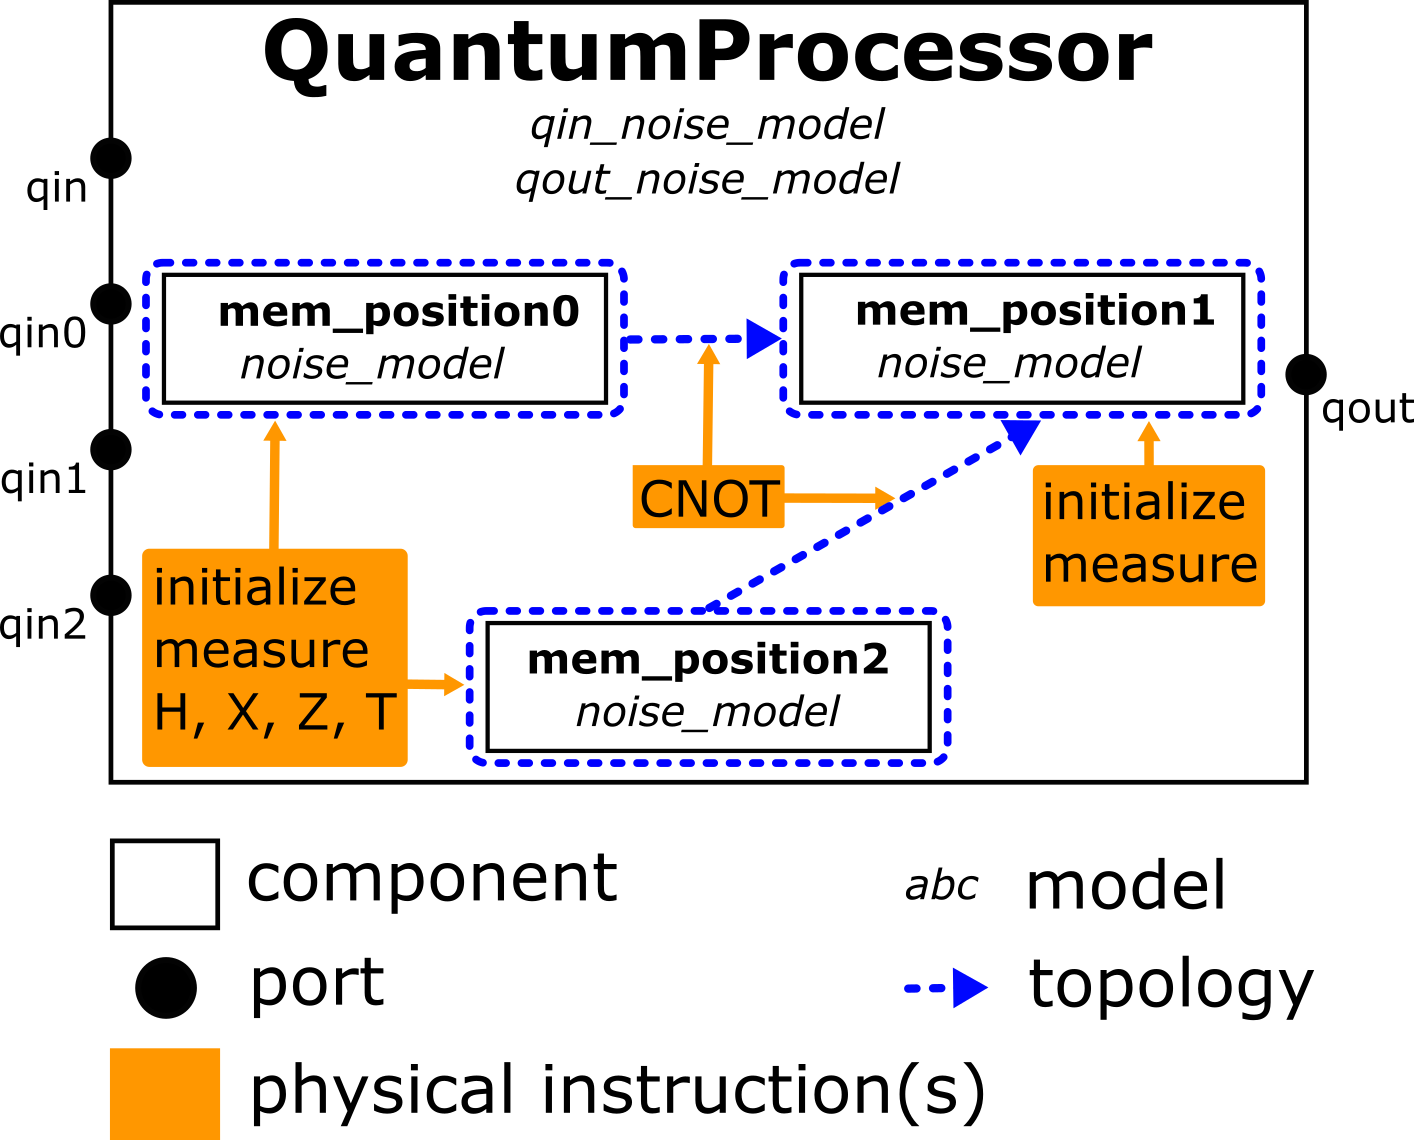

In [ ]:
ns.sim_time()

100.0

In [ ]:
noisy_qproc.execute_instruction(instr.INSTR_INIT, [0, 1])

ns.sim_run()

ns.sim_time()

In [ ]:
ns.sim_reset()

Problems arise, however, if we attempt to execute the rest of our entangling circuit: trying to execute instructions while earlier instructions have not finished yet will result in an error indicating that the processor is still busy.

We need the entity called quantum programs to apply instructions sequentially.

In [ ]:
from netsquid.components.qprogram import QuantumProgram

prog = QuantumProgram(num_qubits=2)
q1, q2 = prog.get_qubit_indices(2)  # Get the qubit indices we'll be working with
prog.apply(instr.INSTR_INIT, [q1, q2])
prog.apply(instr.INSTR_H, q1)
prog.apply(instr.INSTR_CNOT, [q1, q2])
prog.apply(instr.INSTR_MEASURE, q1, output_key="m1")
prog.apply(instr.INSTR_MEASURE, q2, output_key="m2")

In [ ]:
noisy_qproc.reset()
ns.sim_reset()
noisy_qproc.execute_program(prog, qubit_mapping = [2, 1])
ns.sim_run()
ns.sim_time()

In [ ]:
prog.output["m1"] == prog.output["m2"]

In [ ]:
prog.output["m1"], prog.output["m2"]

Alternativelly...

In [ ]:
class EntangleProgram(QuantumProgram):

    default_num_qubits = 2

    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_INIT, [q1, q2])
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_CNOT, [q1, q2])
        self.apply(instr.INSTR_MEASURE, q1, output_key="m1")
        self.apply(instr.INSTR_MEASURE, q2, output_key="m2")

        yield self.run()


During run() instructions store their output in a local state dictionary called output.

In [ ]:
class ControlledQProgram(QuantumProgram):

    default_num_qubits = 3

    def program(self):
        q1, q2, q3 = self.get_qubit_indices(3)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key="m1")

        yield self.run()

        # Depending on outcome on q1 either flip q2 or q3
        if self.output["m1"][0] == 0:
            self.apply(instr.INSTR_X, q2)
        else:
            self.apply(instr.INSTR_X, q3)

        self.apply(instr.INSTR_MEASURE, q2, output_key="m2")
        self.apply(instr.INSTR_MEASURE, q3, output_key="m3")

        yield self.run(parallel=False)


Let us use programs to perform a local teleportation example between the qubits on a single quantum processor with imperfect physical instructions i.e. teleport the state of a qubit on position 0 to memory position 2.

In [ ]:
noisy_qproc.reset()
ns.sim_reset()
ns.set_qstate_formalism(ns.QFormalism.DM)

class TeleportationProgram(QuantumProgram):

    default_num_qubits = 3

    def program(self):
        q0, q1, q2 = self.get_qubit_indices(3)

        # Entangle q1 and q2:
        self.apply(instr.INSTR_INIT, [q0, q1, q2])
        self.apply(instr.INSTR_H, q2)
        self.apply(instr.INSTR_CNOT, [q2, q1])

        # Set q0 to the desired state to be teleported:
        self.apply(instr.INSTR_H, q0)
        self.apply(instr.INSTR_S, q0)

        # Bell measurement:
        self.apply(instr.INSTR_CNOT, [q0, q1])
        self.apply(instr.INSTR_H, q0)
        self.apply(instr.INSTR_MEASURE, q0, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q1, output_key="M2")
        yield self.run()

        # Do corrections:
        if self.output["M2"][0] == 1:
            self.apply(instr.INSTR_X, q2)
        if self.output["M1"][0] == 1:
            self.apply(instr.INSTR_Z, q2)

        yield self.run()

noisy_qproc.execute_program(TeleportationProgram())
ns.sim_run()
qubit = noisy_qproc.pop(2)
fidelity = ns.qubits.fidelity(
    qubit, ns.qubits.outerprod((ns.S*ns.H*ns.s0).arr), squared=True)
print(f"{fidelity:.3f}")

A program can load in another program using the load() method. Loaded programs share the output dictionary.

In [ ]:
class LoadingQProgram(QuantumProgram):
    default_num_qubits = 2

    def program(self):
        # Run a regular sequence
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_X, q1)
        yield self.run()

        # Load and run another program
        yield from self.load(CheatingQProgram)

Programs can be concatenated using the addition operator, where one of the operands can also be a class instead of an instance:

prog3 = prog1 + prog2  

Programs can be repeated using the multiplication operator:

prog2 = prog1 * 5  

In all cases the output dictionary is shared among the combined programs.

Wrap up

In [ ]:
class EntanglingConnection(Connection):
    """A connection that generates entanglement.
    Consists of a midpoint holding a quantum source that connects to
    outgoing quantum channels.

    Parameters
    ----------
    length : float
        End to end length of the connection [km].
    source_frequency : float
        Frequency with which midpoint entanglement source generates entanglement [Hz].
    name : str, optional
        Name of this connection.

    """

    def __init__(self, length, source_frequency, name="EntanglingConnection"):
        super().__init__(name=name)
        qsource = QSource(f"qsource_{name}", StateSampler([ks.b00], [1.0]), num_ports=2,
                          timing_model=FixedDelayModel(delay=1e9 / source_frequency),
                          status=SourceStatus.INTERNAL)
        self.add_subcomponent(qsource, name="qsource")
        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        # Add channels and forward quantum channel output to external port output:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])
        # Connect qsource output to quantum channel input:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"])
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])

In [ ]:
class ClassicalConnection(Connection):
    """A connection that transmits classical messages in one direction, from A to B.

    Parameters
    ----------
    length : float
        End to end length of the connection [km].
    name : str, optional
       Name of this connection.

    """

    def __init__(self, length, name="ClassicalConnection"):
        super().__init__(name=name)
        self.add_subcomponent(ClassicalChannel("Channel_A2B", length=length,
                                               models={"delay_model": FibreDelayModel()}),
                              forward_input=[("A", "send")],
                              forward_output=[("B", "recv")])

In [ ]:
def create_processor(depolar_rate, dephase_rate):
    """Factory to create a quantum processor for each end node.

    Has two memory positions and the physical instructions necessary
    for teleportation.

    Parameters
    ----------
    depolar_rate : float
        Depolarization rate of qubits in memory.
    dephase_rate : float
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`~netsquid.components.qprocessor.QuantumProcessor`
        A quantum processor to specification.

    """
    # We'll give both Alice and Bob the same kind of processor
    measure_noise_model = DephaseNoiseModel(dephase_rate=dephase_rate,
                                            time_independent=True)
    physical_instructions = [
        PhysicalInstruction(instr.INSTR_INIT, duration=3, parallel=True),
        PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 1]),
        PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True, topology=[(0, 1)]),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[0],
                            quantum_noise_model=measure_noise_model, apply_q_noise_after=False),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[1])
    ]
    memory_noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)
    processor = QuantumProcessor("quantum_processor", num_positions=2,
                                 memory_noise_models=[memory_noise_model] * 2,
                                 phys_instructions=physical_instructions)
    return processor

In [ ]:
def example_network_setup(node_distance=4e-3, depolar_rate=1e7, dephase_rate=0.2):
    """Setup the physical components of the quantum network.

    Parameters
    ----------
    node_distance : float, optional
        Distance between nodes.
    depolar_rate : float, optional
        Depolarization rate of qubits in memory.
    dephase_rate : float, optional
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`~netsquid.nodes.node.Network`
        A Network with nodes "Alice" and "Bob",
        connected by an entangling connection and a classical connection

    """
    # Setup nodes Alice and Bob with quantum processor:
    alice = Node("Alice", qmemory=create_processor(depolar_rate, dephase_rate))
    bob = Node("Bob", qmemory=create_processor(depolar_rate, dephase_rate))
    # Create a network
    network = Network("Teleportation_network")
    network.add_nodes([alice, bob])
    # Setup classical connection between nodes:
    c_conn = ClassicalConnection(length=node_distance)
    network.add_connection(alice, bob, connection=c_conn, label="classical",
                           port_name_node1="cout_bob", port_name_node2="cin_alice")
    # Setup entangling connection between nodes:
    source_frequency = 4e4 / node_distance
    q_conn = EntanglingConnection(
        length=node_distance, source_frequency=source_frequency)
    port_ac, port_bc = network.add_connection(
        alice, bob, connection=q_conn, label="quantum",
        port_name_node1="qin_charlie", port_name_node2="qin_charlie")
    alice.ports[port_ac].forward_input(alice.qmemory.ports['qin1'])
    bob.ports[port_bc].forward_input(bob.qmemory.ports['qin0'])
    return network

In [ ]:
class InitStateProgram(QuantumProgram):
    """Program to create a qubit and transform it to the y0 state.

    """
    default_num_qubits = 1

    def program(self):
        q1, = self.get_qubit_indices(1)
        self.apply(instr.INSTR_INIT, q1)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_S, q1)
        yield self.run()

In [ ]:
class BellMeasurementProgram(QuantumProgram):
    """Program to perform a Bell measurement on two qubits.

    Measurement results are stored in output keys "M1" and "M2"

    """
    default_num_qubits = 2

    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_CNOT, [q1, q2])
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q2, output_key="M2")
        yield self.run()

In [ ]:
class BellMeasurementProtocol(NodeProtocol):
    """Protocol to perform a Bell measurement when qubits are available.

    """

    def run(self):
        qubit_initialised = False
        entanglement_ready = False
        qubit_init_program = InitStateProgram()
        measure_program = BellMeasurementProgram()
        self.node.qmemory.execute_program(qubit_init_program)
        while True:
            expr = yield (self.await_program(self.node.qmemory) |
                          self.await_port_input(self.node.ports["qin_charlie"]))
            if expr.first_term.value:
                qubit_initialised = True
            else:
                entanglement_ready = True
            if qubit_initialised and entanglement_ready:
                # Once both qubits arrived, do BSM program and send to Bob
                yield self.node.qmemory.execute_program(measure_program)
                m1, = measure_program.output["M1"]
                m2, = measure_program.output["M2"]
                self.node.ports["cout_bob"].tx_output((m1, m2))
                self.send_signal(Signals.SUCCESS)
                qubit_initialised = False
                entanglement_ready = False
                self.node.qmemory.execute_program(qubit_init_program)

In [ ]:
class CorrectionProtocol(NodeProtocol):
    """Protocol to perform corrections on Bobs qubit when available and measurements received

    """

    def run(self):
        port_alice = self.node.ports["cin_alice"]
        port_charlie = self.node.ports["qin_charlie"]
        entanglement_ready = False
        meas_results = None
        while True:
            # Wait for measurement results of Alice or qubit from Charlie to arrive
            expr = yield (self.await_port_input(port_alice) |
                          self.await_port_input(port_charlie))
            if expr.first_term.value:  # If measurements from Alice arrived
                meas_results, = port_alice.rx_input().items
            else:
                entanglement_ready = True
            if meas_results is not None and entanglement_ready:
                # Do corrections (blocking)
                if meas_results[0] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_Z)
                    yield self.await_program(self.node.qmemory)
                if meas_results[1] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_X)
                    yield self.await_program(self.node.qmemory)
                self.send_signal(Signals.SUCCESS, 0)
                entanglement_ready = False
                meas_results = None

In [ ]:
def example_sim_setup(node_A, node_B):
    """Example simulation setup with data collector for teleportation protocol.

    Parameters
    ----------
    node_A : :class:`~netsquid.nodes.node.Node`
        Node corresponding to Alice.
    node_B : :class:`~netsquid.nodes.node.Node`
        Node corresponding to Bob.

    Returns
    -------
    :class:`~netsquid.protocols.protocol.Protocol`
        Alice's protocol.
    :class:`~netsquid.protocols.protocol.Protocol`
        Bob's protocol.
    :class:`~netsquid.util.datacollector.DataCollector`
        Data collector to record fidelity.

    """

    def collect_fidelity_data(evexpr):
        protocol = evexpr.triggered_events[-1].source
        mem_pos = protocol.get_signal_result(Signals.SUCCESS)
        qubit, = protocol.node.qmemory.pop(mem_pos)
        fidelity = qapi.fidelity(qubit, ns.y0, squared=True)
        qapi.discard(qubit)
        return {"fidelity": fidelity}

    protocol_alice = BellMeasurementProtocol(node_A)
    protocol_bob = CorrectionProtocol(node_B)
    dc = DataCollector(collect_fidelity_data)
    dc.collect_on(pydynaa.EventExpression(source=protocol_bob,
                                          event_type=Signals.SUCCESS.value))
    return protocol_alice, protocol_bob, dc

In [ ]:
def run_experiment(num_runs, depolar_rates, distance=4e-3, dephase_rate=0.0):
    """Setup and run the simulation experiment.

    Parameters
    ----------
    num_runs : int
        Number of cycles to run teleportation for.
    depolar_rates : list of float
        List of depolarization rates to repeat experiment for.
    distance : float, optional
        Distance between nodes [km].
    dephase_rate : float, optional
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`pandas.DataFrame`
        Dataframe with recorded fidelity data.

    """
    fidelity_data = pandas.DataFrame()
    for depolar_rate in depolar_rates:
        ns.sim_reset()
        network = example_network_setup(distance, depolar_rate, dephase_rate)
        node_a = network.get_node("Alice")
        node_b = network.get_node("Bob")
        protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
        protocol_alice.start()
        protocol_bob.start()
        q_conn = network.get_connection(node_a, node_b, label="quantum")
        cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                         .models["timing_model"].delay)
        ns.sim_run(cycle_runtime * num_runs + 1)
        df = dc.dataframe
        df['depolar_rate'] = depolar_rate
        fidelity_data = pandas.concat([fidelity_data, df])
    return fidelity_data

In [ ]:
def create_plot():
    """Show a plot of fidelity verus depolarization rate.

    """
    from matplotlib import pyplot as plt
    depolar_rates = [1e6 * i for i in range(0, 200, 10)]
    fidelities = run_experiment(num_runs=1000, distance=4e-3,
                                depolar_rates=depolar_rates, dephase_rate=0.0)
    plot_style = {'kind': 'scatter', 'grid': True,
                  'title': "Fidelity of the teleported quantum state"}
    data = fidelities.groupby("depolar_rate")['fidelity'].agg(
        fidelity='mean', sem='sem').reset_index()
    data.plot(x='depolar_rate', y='fidelity', yerr='sem', **plot_style)
    plt.show()


In [ ]:
create_plot()

As entangled states are propagated across a quantum network, they accumulate noise, which reduces entanglement quality. Entanglement purification is a quantum network protocol used to improve the quality of entanglement and counteract the impact of noise.

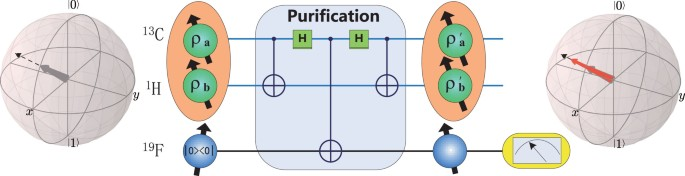

In [ ]:
def example_network_setup(source_delay=1e5, source_fidelity_sq=0.8, depolar_rate=1000,
                          node_distance=20):
    """Create an example network for use with the purification protocols.

    Returns
    -------
    :class:`~netsquid.components.component.Component`
        A network component with nodes and channels as subcomponents.

    Notes
    -----
        This network is also used by the matching integration test.

    """
    network = Network("purify_network")

    node_a, node_b = network.add_nodes(["node_A", "node_B"])
    node_a.add_subcomponent(QuantumProcessor(
        "QuantumMemory_A", num_positions=2, fallback_to_nonphysical=True,
        memory_noise_models=DepolarNoiseModel(depolar_rate)))
    state_sampler = StateSampler(
        [ks.b01, ks.s00],
        probabilities=[source_fidelity_sq, 1 - source_fidelity_sq])
    node_a.add_subcomponent(QSource(
        "QSource_A", state_sampler=state_sampler,
        models={"emission_delay_model": FixedDelayModel(delay=source_delay)},
        num_ports=2, status=SourceStatus.EXTERNAL))
    node_b.add_subcomponent(QuantumProcessor(
        "QuantumMemory_B", num_positions=2, fallback_to_nonphysical=True,
        memory_noise_models=DepolarNoiseModel(depolar_rate)))
    conn_cchannel = DirectConnection(
        "CChannelConn_AB",
        ClassicalChannel("CChannel_A->B", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}),
        ClassicalChannel("CChannel_B->A", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}))
    network.add_connection(node_a, node_b, connection=conn_cchannel)
    # node_A.connect_to(node_B, conn_cchannel)
    qchannel = QuantumChannel("QChannel_A->B", length=node_distance,
                              models={"quantum_loss_model": None,
                                      "delay_model": FibreDelayModel(c=200e3)},
                              depolar_rate=0)
    port_name_a, port_name_b = network.add_connection(
        node_a, node_b, channel_to=qchannel, label="quantum")
    # Link Alice ports:
    node_a.subcomponents["QSource_A"].ports["qout1"].forward_output(
        node_a.ports[port_name_a])
    node_a.subcomponents["QSource_A"].ports["qout0"].connect(
        node_a.qmemory.ports["qin0"])
    # Link Bob ports:
    node_b.ports[port_name_b].forward_input(node_b.qmemory.ports["qin0"])
    return network

aafig-39caf280a15d0c5a7fc917769f6f4dc32d0f6476.svg

In [ ]:
def example_sim_setup(node_a, node_b, num_runs, epsilon=0.3):
    """Example simulation setup for purification protocols.

    Returns
    -------
    :class:`~netsquid.examples.purify.FilteringExample`
        Example protocol to run.
    :class:`pandas.DataFrame`
        Dataframe of collected data.

    """
    filt_example = FilteringExample(node_a, node_b, num_runs=num_runs, epsilon=0.3)

    def record_run(evexpr):
        # Callback that collects data each run
        protocol = evexpr.triggered_events[-1].source
        result = protocol.get_signal_result(Signals.SUCCESS)
        # Record fidelity
        q_A, = node_a.qmemory.pop(positions=[result["pos_A"]])
        q_B, = node_b.qmemory.pop(positions=[result["pos_B"]])
        f2 = qapi.fidelity([q_A, q_B], ks.b01, squared=True)
        return {"F2": f2, "pairs": result["pairs"], "time": result["time"]}

    dc = DataCollector(record_run, include_time_stamp=False,
                       include_entity_name=False)
    dc.collect_on(pd.EventExpression(source=filt_example,
                                     event_type=Signals.SUCCESS.value))
    return filt_example, dc

In [ ]:
import netsquid as ns

from netsquid.examples.purify import example_network_setup, example_sim_setup

network = example_network_setup()
filt_example, dc = example_sim_setup(
    network.get_node("node_A"), network.get_node("node_B"), num_runs=1000)
filt_example.start()
ns.sim_run()
print("Average fidelity of generated entanglement with filtering: {}"
      .format(dc.dataframe["F2"].mean()))

Repeater protocol

aafig-7a1f9d9b8c565b08b9bdb70f5f48bd286ec222db.svg

The repeaters will use a so-called entanglement swapping scheme to entangle the end nodes, which consists of the following steps:
    
*   generating entanglement with both of its neighbours,

*   measuring its two locally stored qubits in the Bell basis,

*   sending its own measurement outcomes to its right neighbour, and also forwarding on outcomes received from its left neighbour in this way.





In [ ]:
def example_network_setup(source_delay=1e5, source_fidelity_sq=0.8, depolar_rate=1000,
                          node_distance=20):
    """Create an example network for use with the repeater protocols.

    Returns
    -------
    :class:`~netsquid.components.component.Component`
        A network component with nodes and channels as subcomponents.

    Notes
    -----
        This network is also used by the matching integration test.

    """
    network = Network("Repeater_network")
    state_sampler = StateSampler(
        [ks.b01, ks.s00],
        probabilities=[source_fidelity_sq, 1 - source_fidelity_sq])
    node_a, node_b, node_r = network.add_nodes(["node_A", "node_B", "node_R"])
    # Setup end-node A:
    node_a.add_subcomponent(QuantumProcessor(
        "quantum_processor_a", num_positions=2, fallback_to_nonphysical=True,
        memory_noise_models=DepolarNoiseModel(depolar_rate)))
    source_a = QSource(
        "QSource_A", state_sampler=state_sampler, num_ports=2, status=SourceStatus.EXTERNAL,
        models={"emission_delay_model": FixedDelayModel(delay=source_delay)})
    node_a.add_subcomponent(source_a)
    # Setup end-node B:
    node_b.add_subcomponent(QuantumProcessor(
        "quantum_processor_b", num_positions=2, fallback_to_nonphysical=True,
        memory_noise_models=DepolarNoiseModel(depolar_rate)))
    source_b = QSource(
        "QSource_B", state_sampler=state_sampler, num_ports=2, status=SourceStatus.EXTERNAL,
        models={"emission_delay_model": FixedDelayModel(delay=source_delay)})
    node_b.add_subcomponent(source_b)
    # Setup midpoint repeater node R
    node_r.add_subcomponent(QuantumProcessor(
        "quantum_processor_r", num_positions=4, fallback_to_nonphysical=True,
        memory_noise_models=DepolarNoiseModel(depolar_rate)))
    # Setup classical connections
    conn_cfibre_ar = DirectConnection(
        "CChannelConn_AR",
        ClassicalChannel("CChannel_A->R", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}),
        ClassicalChannel("CChannel_R->A", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}))
    network.add_connection(node_a, node_r, connection=conn_cfibre_ar)
    conn_cfibre_br = DirectConnection(
        "CChannelConn_BR",
        ClassicalChannel("CChannel_B->R", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}),
        ClassicalChannel("CChannel_R->B", length=node_distance,
                         models={"delay_model": FibreDelayModel(c=200e3)}))
    network.add_connection(node_b, node_r, connection=conn_cfibre_br)
    # Setup quantum channels
    qchannel_ar = QuantumChannel(
        "QChannel_A->R", length=node_distance,
        models={"quantum_loss_model": None, "delay_model": FibreDelayModel(c=200e3)})
    port_name_a, port_name_ra = network.add_connection(
        node_a, node_r, channel_to=qchannel_ar, label="quantum")
    qchannel_br = QuantumChannel(
        "QChannel_B->R", length=node_distance,
        models={"quantum_loss_model": None, "delay_model": FibreDelayModel(c=200e3)})
    port_name_b, port_name_rb = network.add_connection(
        node_b, node_r, channel_to=qchannel_br, label="quantum")
    # Setup Alice ports:
    node_a.subcomponents["QSource_A"].ports["qout1"].forward_output(
        node_a.ports[port_name_a])
    node_a.subcomponents["QSource_A"].ports["qout0"].connect(
        node_a.qmemory.ports["qin0"])
    # Setup Bob ports:
    node_b.subcomponents["QSource_B"].ports["qout1"].forward_output(
        node_b.ports[port_name_b])
    node_b.subcomponents["QSource_B"].ports["qout0"].connect(
        node_b.qmemory.ports["qin0"])
    # Setup repeater ports:
    node_r.ports[port_name_ra].forward_input(node_r.qmemory.ports["qin0"])
    node_r.ports[port_name_rb].forward_input(node_r.qmemory.ports["qin1"])
    return network

In [ ]:
class RepeaterExample(LocalProtocol):
    """Protocol for a complete repeater experiment including purification.

    Will run for specified number of times then stop, recording results after each run.

    Parameters
    ----------
    node_A : :py:class:`~netsquid.nodes.node.Node`
        Node to be entangled via repeater.
        Must be specified before protocol can start.
    node_B : :py:class:`~netsquid.nodes.node.Node`
        Node to be entangled via repeater.
        Must be specified before protocol can start.
    node_R : :py:class:`~netsquid.nodes.node.Node`
        Repeater node that will entangle nodes A and B.
        Must be specified before protocol can start.
    num_runs : int
        Number of successful runs to do.
    purify : "filter" or "distil" or None, optional
        Purification protocol to run. If None, no purification is done.
    epsilon : float
        Parameter used in filter's measurement operator.

    Subprotocols
    ------------
    entangle_A : :class:`~netsquid.examples.entanglenodes.EntangleNodes`
        Entanglement generation protocol running on node A to entangle with R.
    entangle_Ra : :class:`~netsquid.examples.entanglenodes.EntangleNodes`
        Entanglement generation protocol running on node R to entangle with A.
    entangle_B : :class:`~netsquid.examples.entanglenodes.EntangleNodes`
        Entanglement generation protocol running on node B to entangle with R.
    entangle_Rb : :class:`~netsquid.examples.entanglenodes.EntangleNodes`
        Entanglement generation protocol running on node R to entangle with B.
    purify_A : :class:`Filter` or :class:`Distil`
        Purification protocol running on node A to purify entanglement with R.
    purify_Ra : :class:`Filter` or :class:`Distil`
        Purification protocol running on node R to purify entanglement with A.
    purify_B : :class:`Filter` or :class:`Distil`
        Purification protocol running on node B to purify entanglement with R.
    purify_Rb : :class:`Filter` or :class:`Distil`
        Purification protocol running on node R to purify entanglement with B.
    repeater_R : :class:`~netsquid.examples.repeater.Repeater`
        Repeater protocol running on node R to do midpoint entanglement swap.
    repeater_B : :class:`~netsquid.examples.repeater.Repeater`
        Repeater protocol running on node B to do endpoint correction.

    """

    def __init__(self, node_A, node_B, node_R, num_runs, purify="filter", epsilon=0.3):
        super().__init__(nodes={"A": node_A, "B": node_B, "R": node_R},
                         name="Repeater with purification example")
        self.num_runs = num_runs
        purify = purify.lower()
        if purify not in ("filter", "distil"):
            raise ValueError("{} unknown purify option".format(purify))
        self._add_subprotocols(node_A, node_B, node_R, purify, epsilon)
        # Set entangle start expressions
        start_expr_ent_A = (self.subprotocols["entangle_A"].await_signal(
            self.subprotocols["purify_A"], Signals.FAIL) |
            self.subprotocols["entangle_A"].await_signal(self, Signals.WAITING))
        self.subprotocols["entangle_A"].start_expression = start_expr_ent_A
        start_expr_ent_B = (self.subprotocols["entangle_B"].await_signal(
            self.subprotocols["purify_B"], Signals.FAIL) |
            self.subprotocols["entangle_B"].await_signal(self, Signals.WAITING))
        self.subprotocols["entangle_B"].start_expression = start_expr_ent_B
        # Set purify start expressions
        self._start_on_success("purify_A", "entangle_A")
        self._start_on_success("purify_Ra", "entangle_Ra")
        self._start_on_success("purify_B", "entangle_B")
        self._start_on_success("purify_Rb", "entangle_Rb")
        # Set repeater start expressions
        self._start_on_success("repeater_B", "purify_B")
        start_expr_repeater = (self.subprotocols["repeater_R"].await_signal(
            self.subprotocols["purify_Ra"], Signals.SUCCESS) &
            self.subprotocols["repeater_R"].await_signal(
                self.subprotocols["purify_Rb"], Signals.SUCCESS))
        self.subprotocols["repeater_R"].start_expression = start_expr_repeater

    def _start_on_success(self, start_subprotocol, success_subprotocol):
        # Convenience method to set subprotocol's start expression to be success of another
        self.subprotocols[start_subprotocol].start_expression = (
            self.subprotocols[start_subprotocol].await_signal(
                self.subprotocols[success_subprotocol], Signals.SUCCESS))

    def run(self):
      self.start_subprotocols()
      for i in range(self.num_runs):
          start_time = sim_time()
          self.subprotocols["entangle_A"].entangled_pairs = 0
          self.subprotocols["entangle_B"].entangled_pairs = 0
          self.send_signal(Signals.WAITING)
          yield (self.await_signal(self.subprotocols["purify_A"], Signals.SUCCESS) &
                self.await_signal(self.subprotocols["repeater_B"], Signals.SUCCESS))
          signal_A = self.subprotocols["purify_A"].get_signal_result(
              label=Signals.SUCCESS, receiver=self)
          signal_B = self.subprotocols["repeater_B"].get_signal_result(
              label=Signals.SUCCESS, receiver=self)
          result = {
              "pos_A": signal_A,
              "pos_B": signal_B,
              "time": sim_time() - start_time,
              "pairs_A": self.subprotocols["entangle_A"].entangled_pairs,
              "pairs_B": self.subprotocols["entangle_B"].entangled_pairs,
          }
          self.send_signal(Signals.SUCCESS, result)

In [ ]:
def example_sim_setup(node_A, node_B, node_R, num_runs, purify="filter", epsilon=0.3):
    """Example simulation setup of repeater protocol.

    Returns
    -------
    :class:`~netsquid.examples.repeater.RepeaterExample`
        Example protocol to run.
    :class:`pandas.DataFrame`
        Dataframe of collected data.

    """
    repeater_example = RepeaterExample(
        node_A, node_B, node_R, num_runs=num_runs, purify=purify, epsilon=0.3)

    def record_run(evexpr):
        # Record a repeater run
        protocol = evexpr.triggered_events[-1].source
        result = protocol.get_signal_result(Signals.SUCCESS)
        # Record fidelity
        q_a, = node_A.qmemory.pop(positions=[result["pos_A"]])
        q_b, = node_B.qmemory.pop(positions=[result["pos_B"]])
        f2 = qapi.fidelity([q_a, q_b], ks.b00, squared=True)
        return {"F2": f2,
                "pairs_A": result["pairs_A"],
                "pairs_B": result["pairs_B"],
                "time": result["time"]}

    dc = DataCollector(record_run, include_time_stamp=False, include_entity_name=False)
    dc.collect_on(pd.EventExpression(
        source=repeater_example, event_type=Signals.SUCCESS.value))
    return repeater_example, dc

In [ ]:
import netsquid as ns

from netsquid.examples.repeater import example_network_setup, example_sim_setup

network = example_network_setup()

repeater_example, dc = example_sim_setup(
    network.get_node("node_A"), network.get_node("node_B"),
    network.get_node("node_R"), num_runs=1000)

repeater_example.start()
ns.sim_run()

print("Average fidelity of generated entanglement via a repeater "
      "and with filtering: {}".format(dc.dataframe["F2"].mean()))

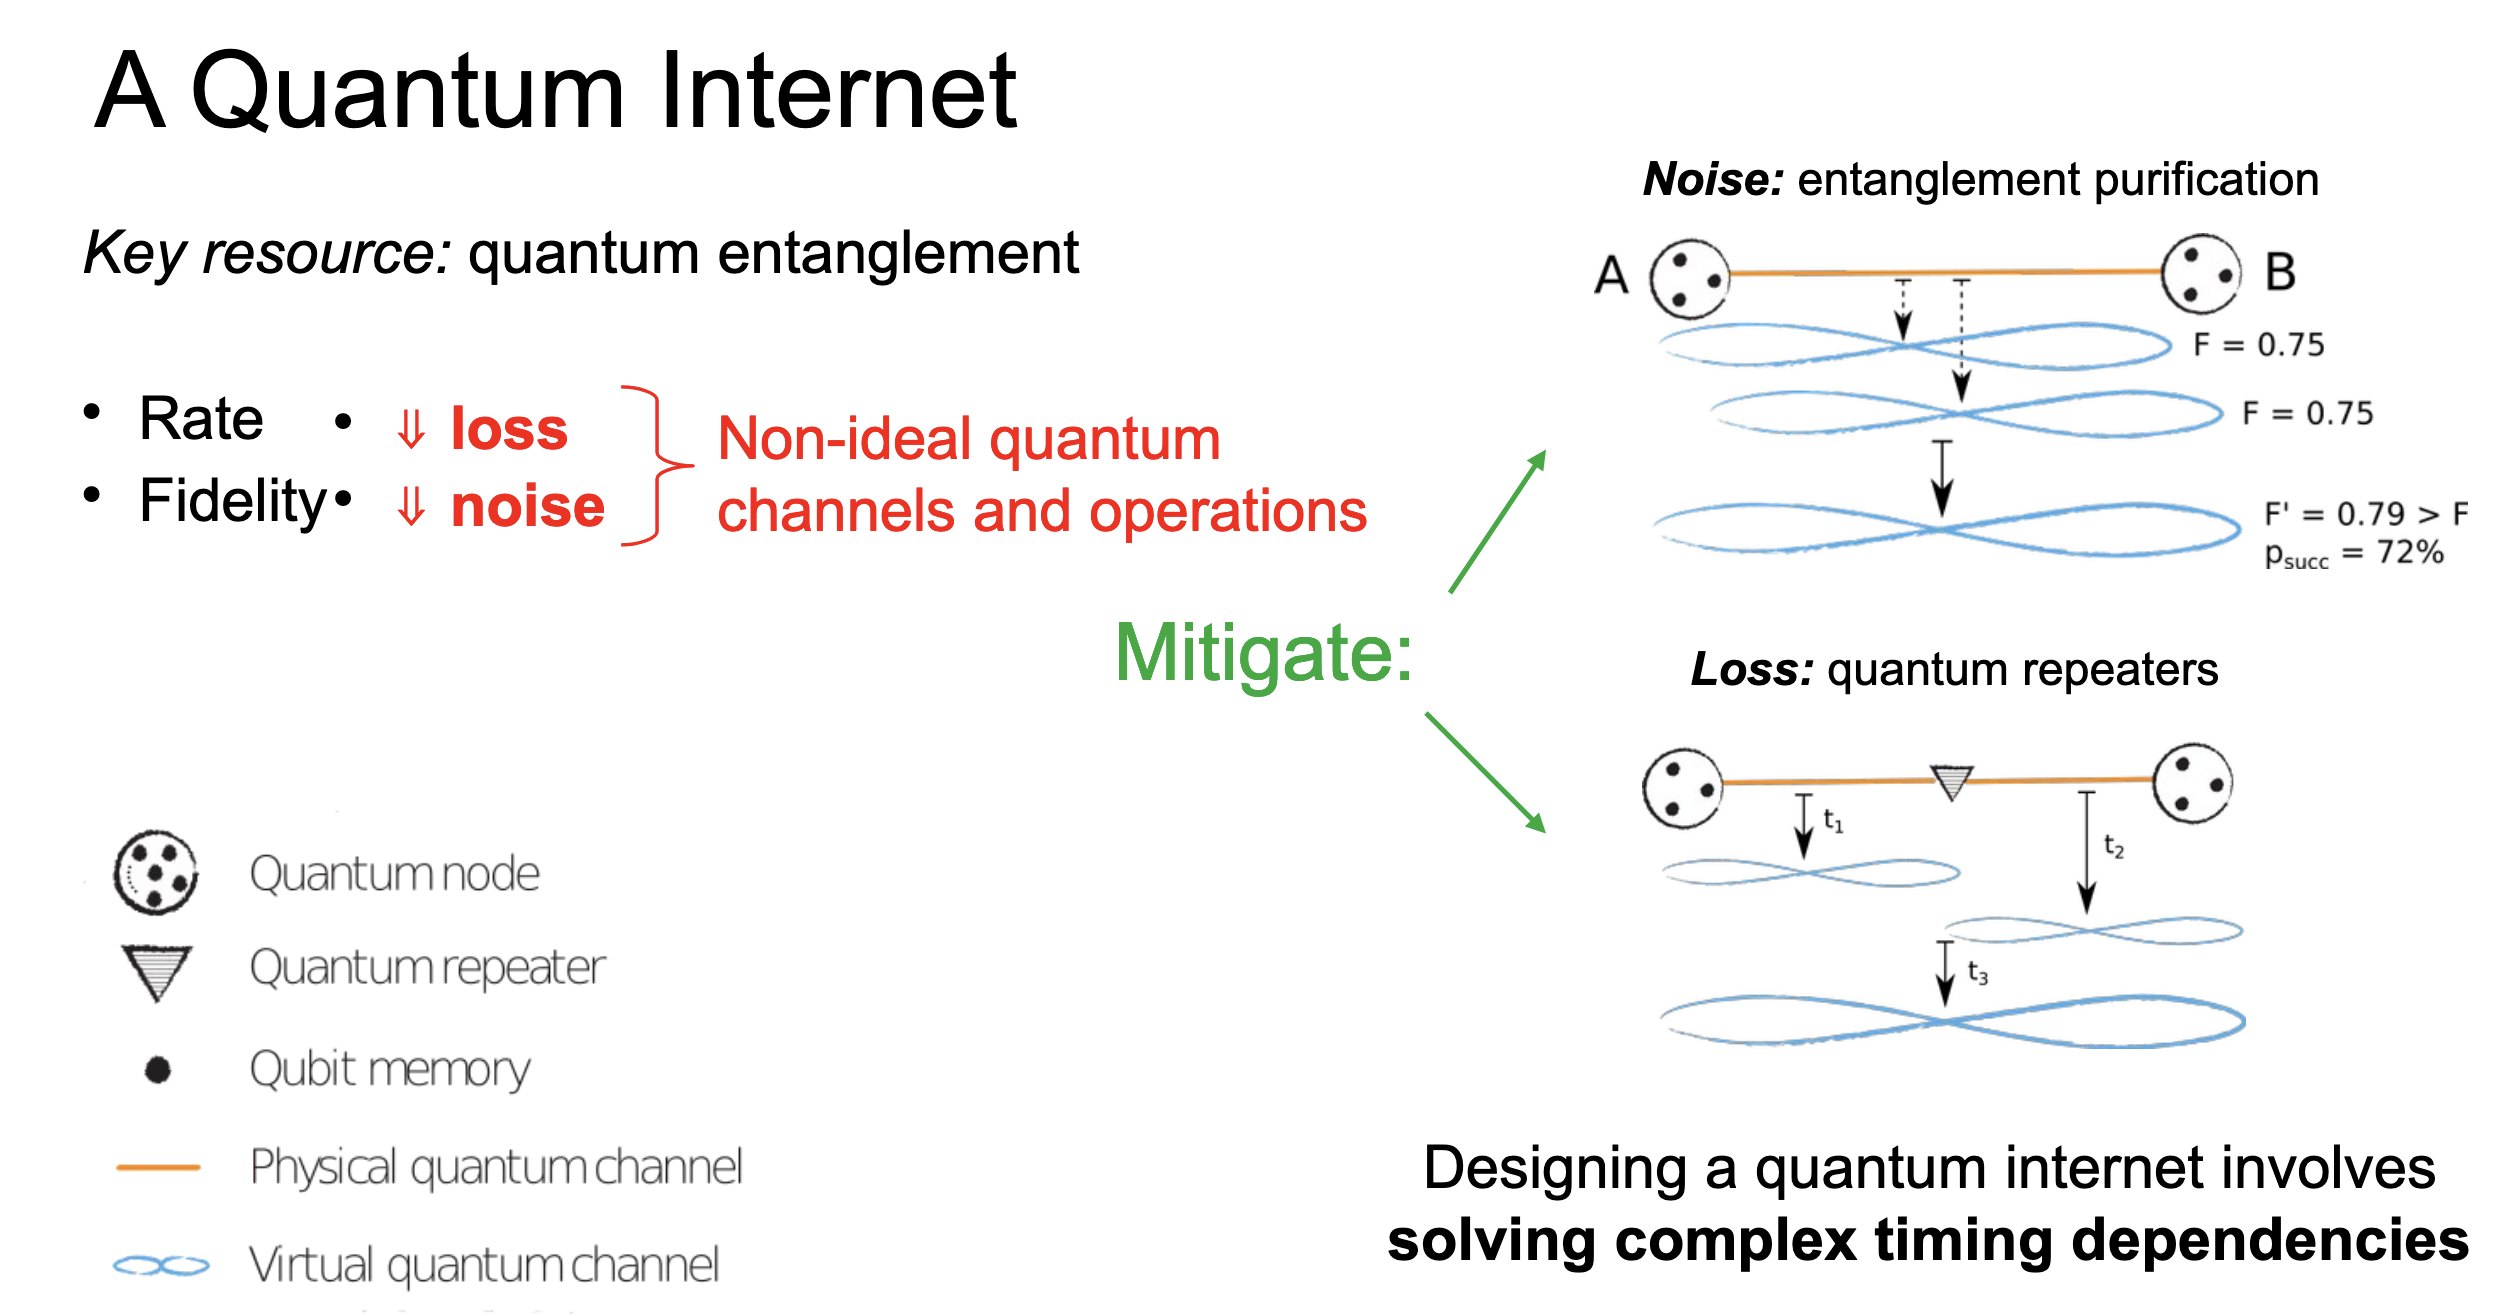

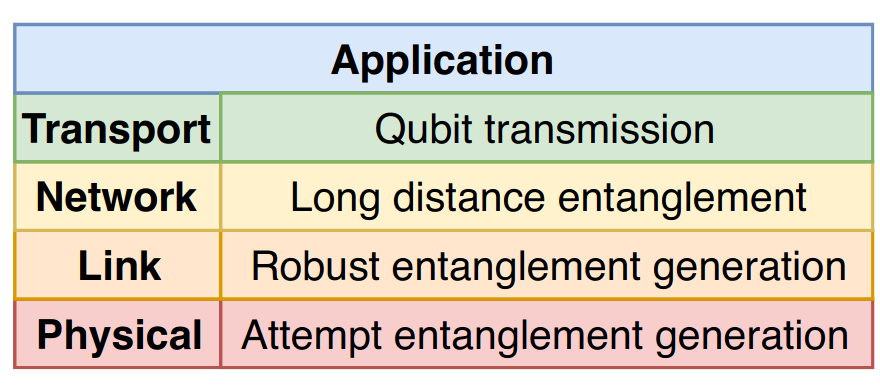